##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Object Detection with TensorFlow Lite Model Maker

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/models/modify/model_maker/object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/models/modify/model_maker/object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/models/modify/model_maker/object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/models/modify/model_maker) library to train a custom object detection model capable of detecting salads within images on a mobile device.

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

You'll use the publicly available *Salads* dataset, which was created from the [Open Images Dataset V4](https://storage.googleapis.com/openimages/web/index.html).

Each image in the dataset contains objects labeled as one of the following classes:
* Baked Good
* Cheese
* Salad
* Seafood
* Tomato

The dataset contains the bounding-boxes specifying where each object locates, together with the object's label.

Here is an example image from the dataset:

<br/>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="0">




## Prerequisites


### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [1]:
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools
!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0

Password:

Import the required packages.

In [3]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

### Prepare the dataset

Here you'll use the same dataset as the AutoML [quickstart](https://cloud.google.com/vision/automl/object-detection/docs/edge-quickstart#preparing_a_dataset).

The *Salads* dataset is available at:
 `gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv`.

It contains 175 images for training, 25 images for validation, and 25 images for testing. The dataset has five classes: `Salad`, `Seafood`, `Tomato`, `Baked goods`, `Cheese`.

<br/>

The dataset is provided in CSV format:
```
TRAINING,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Salad,0.0,0.0954,,,0.977,0.957,,
VALIDATION,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Seafood,0.0154,0.1538,,,1.0,0.802,,
TEST,gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg,Tomato,0.0,0.655,,,0.231,0.839,,
```

* Each row corresponds to an object localized inside a larger image, with each object specifically designated as test, train, or validation data. You'll learn more about what that means in a later stage in this notebook.
* The three lines included here indicate **three distinct objects located inside the same image** available at `gs://cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg`.
* Each row has a different label: `Salad`, `Seafood`, `Tomato`, etc.
* Bounding boxes are specified for each image using the top left and bottom right vertices.

Here is a visualzation of these three lines:

<br>

<img src="https://cloud.google.com/vision/automl/object-detection/docs/images/quickstart-preparing_a_dataset.png" width="400" hspace="100">

If you want to know more about how to prepare your own CSV file and the minimum requirements for creating a valid dataset, see the [Preparing your training data](https://cloud.google.com/vision/automl/object-detection/docs/prepare) guide for more details.

If you are new to Google Cloud, you may wonder what the `gs://` URL means. They are URLs of files stored on [Google Cloud Storage](https://cloud.google.com/storage) (GCS). If you make your files on GCS public or [authenticate your client](https://cloud.google.com/storage/docs/authentication#libauth), Model Maker can read those files similarly to your local files.

However, you don't need to keep your images on Google Cloud to use Model Maker. You can use a local path in your CSV file and Model Maker will just work.

## Quickstart

There are six steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite0 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [4]:
spec = model_spec.get('efficientdet_lite0')

**Step 2. Load the dataset.**

Model Maker will take input data in the CSV format. Use the `object_detector.DataLoader.from_csv` method to load the dataset and split them into the training, validation and test images.

* Training images: These images are used to train the object detection model to recognize salad ingredients.
* Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).
* Test images: These images are used to evaluate the final model performance.

You can load the CSV file directly from Google Cloud Storage, but you don't need to keep your images on Google Cloud to use Model Maker. You can specify a local CSV file on your computer, and Model Maker will work just fine.

In [5]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('gs://cloud-ml-data/img/openimage/csv/salads_ml_use.csv')

**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 8` here so you will see that it takes 21 steps to go through the 175 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [6]:
model = object_detector.create(train_data, model_spec=spec, batch_size=8, train_whole_model=True, validation_data=validation_data)

Epoch 1/50



 1/21 [>.............................] - ETA: 10:07 - det_loss: 1.8596 - cls_loss: 1.1410 - box_loss: 0.0144 - reg_l2_loss: 0.0636 - loss: 1.9232 - learning_rate: 0.0080 - gradient_norm: 0.9493


 2/21 [=>............................] - ETA: 2s - det_loss: 1.8511 - cls_loss: 1.1354 - box_loss: 0.0143 - reg_l2_loss: 0.0636 - loss: 1.9147 - learning_rate: 0.0080 - gradient_norm: 0.9544   


 3/21 [===>..........................] - ETA: 2s - det_loss: 1.8279 - cls_loss: 1.1327 - box_loss: 0.0139 - reg_l2_loss: 0.0636 - loss: 1.8915 - learning_rate: 0.0081 - gradient_norm: 0.9123


 4/21 [====>.........................] - ETA: 2s - det_loss: 1.8154 - cls_loss: 1.1335 - box_loss: 0.0136 - reg_l2_loss: 0.0636 - loss: 1.8789 - learning_rate: 0.0081 - gradient_norm: 0.9051


 5/21 [======>.......................] - ETA: 2s - det_loss: 1.8092 - cls_loss: 1.1330 - box_loss: 0.0135 - reg_l2_loss: 0.0636 - loss: 1.8728 - learning_rate: 0.0082 - gradient_norm: 0.8753


 6/21 [=======>......................] - ETA: 2s - det_loss: 1.8094 - cls_loss: 1.1338 - box_loss: 0.0135 - reg_l2_loss: 0.0636 - loss: 1.8729 - learning_rate: 0.0082 - gradient_norm: 0.8613


 7/21 [=========>....................] - ETA: 2s - det_loss: 1.8045 - cls_loss: 1.1326 - box_loss: 0.0134 - reg_l2_loss: 0.0636 - loss: 1.8681 - learning_rate: 0.0083 - gradient_norm: 0.8328


 8/21 [==========>...................] - ETA: 1s - det_loss: 1.7991 - cls_loss: 1.1316 - box_loss: 0.0133 - reg_l2_loss: 0.0636 - loss: 1.8626 - learning_rate: 0.0083 - gradient_norm: 0.8408


 9/21 [===========>..................] - ETA: 1s - det_loss: 1.7952 - cls_loss: 1.1318 - box_loss: 0.0133 - reg_l2_loss: 0.0636 - loss: 1.8587 - learning_rate: 0.0084 - gradient_norm: 0.8441


10/21 [=============>................] - ETA: 1s - det_loss: 1.7920 - cls_loss: 1.1317 - box_loss: 0.0132 - reg_l2_loss: 0.0636 - loss: 1.8556 - learning_rate: 0.0084 - gradient_norm: 0.8242


11/21 [==============>...............] - ETA: 1s - det_loss: 1.7918 - cls_loss: 1.1316 - box_loss: 0.0132 - reg_l2_loss: 0.0636 - loss: 1.8553 - learning_rate: 0.0085 - gradient_norm: 0.8084


12/21 [================>.............] - ETA: 1s - det_loss: 1.7879 - cls_loss: 1.1313 - box_loss: 0.0131 - reg_l2_loss: 0.0636 - loss: 1.8514 - learning_rate: 0.0085 - gradient_norm: 0.8044


13/21 [=================>............] - ETA: 1s - det_loss: 1.7839 - cls_loss: 1.1310 - box_loss: 0.0131 - reg_l2_loss: 0.0636 - loss: 1.8475 - learning_rate: 0.0086 - gradient_norm: 0.8039


14/21 [===================>..........] - ETA: 1s - det_loss: 1.7836 - cls_loss: 1.1301 - box_loss: 0.0131 - reg_l2_loss: 0.0636 - loss: 1.8472 - learning_rate: 0.0086 - gradient_norm: 0.7942


15/21 [====================>.........] - ETA: 0s - det_loss: 1.7775 - cls_loss: 1.1293 - box_loss: 0.0130 - reg_l2_loss: 0.0636 - loss: 1.8410 - learning_rate: 0.0087 - gradient_norm: 0.7854


16/21 [=====================>........] - ETA: 0s - det_loss: 1.7740 - cls_loss: 1.1285 - box_loss: 0.0129 - reg_l2_loss: 0.0636 - loss: 1.8376 - learning_rate: 0.0087 - gradient_norm: 0.7739


17/21 [=======================>......] - ETA: 0s - det_loss: 1.7684 - cls_loss: 1.1274 - box_loss: 0.0128 - reg_l2_loss: 0.0636 - loss: 1.8320 - learning_rate: 0.0088 - gradient_norm: 0.7704


18/21 [========================>.....] - ETA: 0s - det_loss: 1.7640 - cls_loss: 1.1261 - box_loss: 0.0128 - reg_l2_loss: 0.0636 - loss: 1.8276 - learning_rate: 0.0088 - gradient_norm: 0.7668


19/21 [==========================>...] - ETA: 0s - det_loss: 1.7590 - cls_loss: 1.1262 - box_loss: 0.0127 - reg_l2_loss: 0.0636 - loss: 1.8226 - learning_rate: 0.0089 - gradient_norm: 0.7721


20/21 [===========================>..] - ETA: 0s - det_loss: 1.7539 - cls_loss: 1.1252 - box_loss: 0.0126 - reg_l2_loss: 0.0636 - loss: 1.8175 - learning_rate: 0.0089 - gradient_norm: 0.7709


21/21 [==============================] - ETA: 0s - det_loss: 1.7505 - cls_loss: 1.1241 - box_loss: 0.0125 - reg_l2_loss: 0.0636 - loss: 1.8141 - learning_rate: 0.0090 - gradient_norm: 0.7724


21/21 [==============================] - 39s 411ms/step - det_loss: 1.7474 - cls_loss: 1.1230 - box_loss: 0.0125 - reg_l2_loss: 0.0636 - loss: 1.8110 - learning_rate: 0.0090 - gradient_norm: 0.7739 - val_det_loss: 1.6462 - val_cls_loss: 1.0971 - val_box_loss: 0.0110 - val_reg_l2_loss: 0.0636 - val_loss: 1.7097


Epoch 2/50



 1/21 [>.............................] - ETA: 3s - det_loss: 1.6383 - cls_loss: 1.1039 - box_loss: 0.0107 - reg_l2_loss: 0.0636 - loss: 1.7018 - learning_rate: 0.0100 - gradient_norm: 0.6811


 2/21 [=>............................] - ETA: 2s - det_loss: 1.6461 - cls_loss: 1.1071 - box_loss: 0.0108 - reg_l2_loss: 0.0636 - loss: 1.7096 - learning_rate: 0.0100 - gradient_norm: 0.6772


 3/21 [===>..........................] - ETA: 2s - det_loss: 1.6414 - cls_loss: 1.1048 - box_loss: 0.0107 - reg_l2_loss: 0.0636 - loss: 1.7049 - learning_rate: 0.0100 - gradient_norm: 0.7221


 4/21 [====>.........................] - ETA: 2s - det_loss: 1.6549 - cls_loss: 1.1032 - box_loss: 0.0110 - reg_l2_loss: 0.0636 - loss: 1.7184 - learning_rate: 0.0100 - gradient_norm: 0.7849


 5/21 [======>.......................] - ETA: 2s - det_loss: 1.6677 - cls_loss: 1.1035 - box_loss: 0.0113 - reg_l2_loss: 0.0636 - loss: 1.7312 - learning_rate: 0.0100 - gradient_norm: 0.8488


 6/21 [=======>......................] - ETA: 2s - det_loss: 1.6735 - cls_loss: 1.1003 - box_loss: 0.0115 - reg_l2_loss: 0.0636 - loss: 1.7370 - learning_rate: 0.0100 - gradient_norm: 0.8689


 7/21 [=========>....................] - ETA: 2s - det_loss: 1.6633 - cls_loss: 1.0977 - box_loss: 0.0113 - reg_l2_loss: 0.0636 - loss: 1.7269 - learning_rate: 0.0100 - gradient_norm: 0.8530


 8/21 [==========>...................] - ETA: 1s - det_loss: 1.6566 - cls_loss: 1.0944 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.7202 - learning_rate: 0.0100 - gradient_norm: 0.8340


 9/21 [===========>..................] - ETA: 1s - det_loss: 1.6513 - cls_loss: 1.0918 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.7149 - learning_rate: 0.0100 - gradient_norm: 0.8507


10/21 [=============>................] - ETA: 1s - det_loss: 1.6565 - cls_loss: 1.0895 - box_loss: 0.0113 - reg_l2_loss: 0.0636 - loss: 1.7200 - learning_rate: 0.0100 - gradient_norm: 0.8676


11/21 [==============>...............] - ETA: 1s - det_loss: 1.6575 - cls_loss: 1.0881 - box_loss: 0.0114 - reg_l2_loss: 0.0636 - loss: 1.7211 - learning_rate: 0.0100 - gradient_norm: 0.8541


12/21 [================>.............] - ETA: 1s - det_loss: 1.6535 - cls_loss: 1.0875 - box_loss: 0.0113 - reg_l2_loss: 0.0636 - loss: 1.7171 - learning_rate: 0.0100 - gradient_norm: 0.8700


13/21 [=================>............] - ETA: 1s - det_loss: 1.6454 - cls_loss: 1.0851 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.7090 - learning_rate: 0.0100 - gradient_norm: 0.8826


14/21 [===================>..........] - ETA: 1s - det_loss: 1.6530 - cls_loss: 1.0844 - box_loss: 0.0114 - reg_l2_loss: 0.0636 - loss: 1.7165 - learning_rate: 0.0100 - gradient_norm: 0.8874


15/21 [====================>.........] - ETA: 0s - det_loss: 1.6488 - cls_loss: 1.0818 - box_loss: 0.0113 - reg_l2_loss: 0.0636 - loss: 1.7123 - learning_rate: 0.0100 - gradient_norm: 0.8946


16/21 [=====================>........] - ETA: 0s - det_loss: 1.6461 - cls_loss: 1.0792 - box_loss: 0.0113 - reg_l2_loss: 0.0636 - loss: 1.7096 - learning_rate: 0.0100 - gradient_norm: 0.8869


17/21 [=======================>......] - ETA: 0s - det_loss: 1.6379 - cls_loss: 1.0756 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.7014 - learning_rate: 0.0100 - gradient_norm: 0.9255


18/21 [========================>.....] - ETA: 0s - det_loss: 1.6325 - cls_loss: 1.0727 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.6960 - learning_rate: 0.0100 - gradient_norm: 0.9296


19/21 [==========================>...] - ETA: 0s - det_loss: 1.6290 - cls_loss: 1.0699 - box_loss: 0.0112 - reg_l2_loss: 0.0636 - loss: 1.6925 - learning_rate: 0.0100 - gradient_norm: 0.9329


20/21 [===========================>..] - ETA: 0s - det_loss: 1.6230 - cls_loss: 1.0681 - box_loss: 0.0111 - reg_l2_loss: 0.0636 - loss: 1.6865 - learning_rate: 0.0100 - gradient_norm: 0.9560


21/21 [==============================] - ETA: 0s - det_loss: 1.6201 - cls_loss: 1.0670 - box_loss: 0.0111 - reg_l2_loss: 0.0636 - loss: 1.6836 - learning_rate: 0.0100 - gradient_norm: 0.9723


21/21 [==============================] - 5s 260ms/step - det_loss: 1.6174 - cls_loss: 1.0661 - box_loss: 0.0110 - reg_l2_loss: 0.0636 - loss: 1.6809 - learning_rate: 0.0100 - gradient_norm: 0.9871 - val_det_loss: 1.4184 - val_cls_loss: 0.9289 - val_box_loss: 0.0098 - val_reg_l2_loss: 0.0636 - val_loss: 1.4820


Epoch 3/50



 1/21 [>.............................] - ETA: 3s - det_loss: 1.5332 - cls_loss: 1.0031 - box_loss: 0.0106 - reg_l2_loss: 0.0636 - loss: 1.5968 - learning_rate: 0.0100 - gradient_norm: 1.2522


 2/21 [=>............................] - ETA: 2s - det_loss: 1.5030 - cls_loss: 0.9810 - box_loss: 0.0104 - reg_l2_loss: 0.0636 - loss: 1.5666 - learning_rate: 0.0100 - gradient_norm: 1.1472


 3/21 [===>..........................] - ETA: 2s - det_loss: 1.4860 - cls_loss: 0.9774 - box_loss: 0.0102 - reg_l2_loss: 0.0636 - loss: 1.5496 - learning_rate: 0.0100 - gradient_norm: 1.1715


 4/21 [====>.........................] - ETA: 2s - det_loss: 1.4877 - cls_loss: 0.9765 - box_loss: 0.0102 - reg_l2_loss: 0.0636 - loss: 1.5513 - learning_rate: 0.0100 - gradient_norm: 1.1431


 5/21 [======>.......................] - ETA: 2s - det_loss: 1.4960 - cls_loss: 0.9823 - box_loss: 0.0103 - reg_l2_loss: 0.0636 - loss: 1.5595 - learning_rate: 0.0100 - gradient_norm: 1.1451


 6/21 [=======>......................] - ETA: 2s - det_loss: 1.4737 - cls_loss: 0.9692 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.5372 - learning_rate: 0.0100 - gradient_norm: 1.2427


 7/21 [=========>....................] - ETA: 2s - det_loss: 1.4807 - cls_loss: 0.9774 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.5443 - learning_rate: 0.0100 - gradient_norm: 1.2354


 8/21 [==========>...................] - ETA: 2s - det_loss: 1.4807 - cls_loss: 0.9779 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.5442 - learning_rate: 0.0100 - gradient_norm: 1.2724


 9/21 [===========>..................] - ETA: 1s - det_loss: 1.4749 - cls_loss: 0.9709 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.5384 - learning_rate: 0.0100 - gradient_norm: 1.2664


10/21 [=============>................] - ETA: 1s - det_loss: 1.4788 - cls_loss: 0.9702 - box_loss: 0.0102 - reg_l2_loss: 0.0636 - loss: 1.5423 - learning_rate: 0.0099 - gradient_norm: 1.3665


11/21 [==============>...............] - ETA: 1s - det_loss: 1.4820 - cls_loss: 0.9725 - box_loss: 0.0102 - reg_l2_loss: 0.0636 - loss: 1.5455 - learning_rate: 0.0099 - gradient_norm: 1.4010


12/21 [================>.............] - ETA: 1s - det_loss: 1.4844 - cls_loss: 0.9690 - box_loss: 0.0103 - reg_l2_loss: 0.0636 - loss: 1.5479 - learning_rate: 0.0099 - gradient_norm: 1.3951


13/21 [=================>............] - ETA: 1s - det_loss: 1.4791 - cls_loss: 0.9692 - box_loss: 0.0102 - reg_l2_loss: 0.0636 - loss: 1.5427 - learning_rate: 0.0099 - gradient_norm: 1.4291


14/21 [===================>..........] - ETA: 1s - det_loss: 1.4711 - cls_loss: 0.9665 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.5347 - learning_rate: 0.0099 - gradient_norm: 1.4307


15/21 [====================>.........] - ETA: 0s - det_loss: 1.4725 - cls_loss: 0.9660 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.5361 - learning_rate: 0.0099 - gradient_norm: 1.4209


16/21 [=====================>........] - ETA: 0s - det_loss: 1.4700 - cls_loss: 0.9623 - box_loss: 0.0102 - reg_l2_loss: 0.0636 - loss: 1.5336 - learning_rate: 0.0099 - gradient_norm: 1.4058


17/21 [=======================>......] - ETA: 0s - det_loss: 1.4660 - cls_loss: 0.9590 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.5295 - learning_rate: 0.0099 - gradient_norm: 1.4094


18/21 [========================>.....] - ETA: 0s - det_loss: 1.4542 - cls_loss: 0.9500 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.5178 - learning_rate: 0.0099 - gradient_norm: 1.3964


19/21 [==========================>...] - ETA: 0s - det_loss: 1.4504 - cls_loss: 0.9471 - box_loss: 0.0101 - reg_l2_loss: 0.0636 - loss: 1.5140 - learning_rate: 0.0099 - gradient_norm: 1.3914


20/21 [===========================>..] - ETA: 0s - det_loss: 1.4469 - cls_loss: 0.9445 - box_loss: 0.0100 - reg_l2_loss: 0.0636 - loss: 1.5105 - learning_rate: 0.0099 - gradient_norm: 1.4070


21/21 [==============================] - ETA: 0s - det_loss: 1.4404 - cls_loss: 0.9408 - box_loss: 0.0100 - reg_l2_loss: 0.0636 - loss: 1.5039 - learning_rate: 0.0099 - gradient_norm: 1.4375


21/21 [==============================] - 6s 278ms/step - det_loss: 1.4344 - cls_loss: 0.9374 - box_loss: 0.0099 - reg_l2_loss: 0.0636 - loss: 1.4980 - learning_rate: 0.0099 - gradient_norm: 1.4651 - val_det_loss: 1.4533 - val_cls_loss: 0.9994 - val_box_loss: 0.0091 - val_reg_l2_loss: 0.0636 - val_loss: 1.5169


Epoch 4/50



 1/21 [>.............................] - ETA: 3s - det_loss: 1.3125 - cls_loss: 0.7985 - box_loss: 0.0103 - reg_l2_loss: 0.0636 - loss: 1.3761 - learning_rate: 0.0099 - gradient_norm: 1.3919


 2/21 [=>............................] - ETA: 2s - det_loss: 1.2980 - cls_loss: 0.8346 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.3616 - learning_rate: 0.0099 - gradient_norm: 1.9802


 3/21 [===>..........................] - ETA: 2s - det_loss: 1.3035 - cls_loss: 0.8329 - box_loss: 0.0094 - reg_l2_loss: 0.0636 - loss: 1.3670 - learning_rate: 0.0099 - gradient_norm: 1.7957


 4/21 [====>.........................] - ETA: 2s - det_loss: 1.3353 - cls_loss: 0.8648 - box_loss: 0.0094 - reg_l2_loss: 0.0636 - loss: 1.3988 - learning_rate: 0.0099 - gradient_norm: 2.1028


 5/21 [======>.......................] - ETA: 2s - det_loss: 1.3237 - cls_loss: 0.8553 - box_loss: 0.0094 - reg_l2_loss: 0.0636 - loss: 1.3872 - learning_rate: 0.0099 - gradient_norm: 2.0653


 6/21 [=======>......................] - ETA: 2s - det_loss: 1.3072 - cls_loss: 0.8417 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.3708 - learning_rate: 0.0099 - gradient_norm: 1.9666


 7/21 [=========>....................] - ETA: 2s - det_loss: 1.3116 - cls_loss: 0.8459 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.3752 - learning_rate: 0.0099 - gradient_norm: 1.9932


 8/21 [==========>...................] - ETA: 2s - det_loss: 1.3003 - cls_loss: 0.8323 - box_loss: 0.0094 - reg_l2_loss: 0.0636 - loss: 1.3638 - learning_rate: 0.0099 - gradient_norm: 1.9086


 9/21 [===========>..................] - ETA: 1s - det_loss: 1.2886 - cls_loss: 0.8238 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.3522 - learning_rate: 0.0099 - gradient_norm: 1.8775


10/21 [=============>................] - ETA: 1s - det_loss: 1.2918 - cls_loss: 0.8264 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.3553 - learning_rate: 0.0099 - gradient_norm: 2.0184


11/21 [==============>...............] - ETA: 1s - det_loss: 1.2987 - cls_loss: 0.8296 - box_loss: 0.0094 - reg_l2_loss: 0.0636 - loss: 1.3622 - learning_rate: 0.0099 - gradient_norm: 2.0007


12/21 [================>.............] - ETA: 1s - det_loss: 1.2981 - cls_loss: 0.8323 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.3617 - learning_rate: 0.0099 - gradient_norm: 1.9444


13/21 [=================>............] - ETA: 1s - det_loss: 1.2956 - cls_loss: 0.8306 - box_loss: 0.0093 - reg_l2_loss: 0.0636 - loss: 1.3591 - learning_rate: 0.0099 - gradient_norm: 1.9386


14/21 [===================>..........] - ETA: 1s - det_loss: 1.2855 - cls_loss: 0.8244 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.3490 - learning_rate: 0.0099 - gradient_norm: 1.9830


15/21 [====================>.........] - ETA: 0s - det_loss: 1.2918 - cls_loss: 0.8324 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.3554 - learning_rate: 0.0099 - gradient_norm: 2.0291


16/21 [=====================>........] - ETA: 0s - det_loss: 1.2867 - cls_loss: 0.8288 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.3503 - learning_rate: 0.0099 - gradient_norm: 2.0107


17/21 [=======================>......] - ETA: 0s - det_loss: 1.2868 - cls_loss: 0.8278 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.3504 - learning_rate: 0.0099 - gradient_norm: 1.9968


18/21 [========================>.....] - ETA: 0s - det_loss: 1.2762 - cls_loss: 0.8191 - box_loss: 0.0091 - reg_l2_loss: 0.0636 - loss: 1.3398 - learning_rate: 0.0099 - gradient_norm: 1.9679


19/21 [==========================>...] - ETA: 0s - det_loss: 1.2797 - cls_loss: 0.8204 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.3432 - learning_rate: 0.0099 - gradient_norm: 1.9759


20/21 [===========================>..] - ETA: 0s - det_loss: 1.2812 - cls_loss: 0.8205 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.3448 - learning_rate: 0.0099 - gradient_norm: 1.9622


21/21 [==============================] - ETA: 0s - det_loss: 1.2818 - cls_loss: 0.8213 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.3454 - learning_rate: 0.0099 - gradient_norm: 1.9415


21/21 [==============================] - 6s 304ms/step - det_loss: 1.2824 - cls_loss: 0.8220 - box_loss: 0.0092 - reg_l2_loss: 0.0636 - loss: 1.3460 - learning_rate: 0.0099 - gradient_norm: 1.9227 - val_det_loss: 1.1660 - val_cls_loss: 0.7516 - val_box_loss: 0.0083 - val_reg_l2_loss: 0.0636 - val_loss: 1.2296


Epoch 5/50



 1/21 [>.............................] - ETA: 3s - det_loss: 1.2590 - cls_loss: 0.7751 - box_loss: 0.0097 - reg_l2_loss: 0.0636 - loss: 1.3226 - learning_rate: 0.0098 - gradient_norm: 1.4028


 2/21 [=>............................] - ETA: 2s - det_loss: 1.3048 - cls_loss: 0.8527 - box_loss: 0.0090 - reg_l2_loss: 0.0636 - loss: 1.3684 - learning_rate: 0.0098 - gradient_norm: 1.6519


 3/21 [===>..........................] - ETA: 2s - det_loss: 1.2246 - cls_loss: 0.8086 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.2882 - learning_rate: 0.0098 - gradient_norm: 1.6122


 4/21 [====>.........................] - ETA: 2s - det_loss: 1.2001 - cls_loss: 0.7824 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2637 - learning_rate: 0.0098 - gradient_norm: 1.6369


 5/21 [======>.......................] - ETA: 2s - det_loss: 1.2208 - cls_loss: 0.7943 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2843 - learning_rate: 0.0098 - gradient_norm: 1.6318


 6/21 [=======>......................] - ETA: 2s - det_loss: 1.2023 - cls_loss: 0.7744 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.2658 - learning_rate: 0.0098 - gradient_norm: 1.5555


 7/21 [=========>....................] - ETA: 2s - det_loss: 1.2052 - cls_loss: 0.7800 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2688 - learning_rate: 0.0098 - gradient_norm: 1.6435


 8/21 [==========>...................] - ETA: 1s - det_loss: 1.1940 - cls_loss: 0.7728 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2575 - learning_rate: 0.0098 - gradient_norm: 1.6642


 9/21 [===========>..................] - ETA: 1s - det_loss: 1.2122 - cls_loss: 0.7890 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2758 - learning_rate: 0.0098 - gradient_norm: 1.7032


10/21 [=============>................] - ETA: 1s - det_loss: 1.2135 - cls_loss: 0.7883 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2771 - learning_rate: 0.0098 - gradient_norm: 1.7067


11/21 [==============>...............] - ETA: 1s - det_loss: 1.2001 - cls_loss: 0.7759 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2637 - learning_rate: 0.0098 - gradient_norm: 1.6732


12/21 [================>.............] - ETA: 1s - det_loss: 1.1876 - cls_loss: 0.7653 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.2512 - learning_rate: 0.0098 - gradient_norm: 1.6515


13/21 [=================>............] - ETA: 1s - det_loss: 1.1963 - cls_loss: 0.7712 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2599 - learning_rate: 0.0098 - gradient_norm: 1.6292


14/21 [===================>..........] - ETA: 1s - det_loss: 1.2022 - cls_loss: 0.7762 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2658 - learning_rate: 0.0098 - gradient_norm: 1.7006


15/21 [====================>.........] - ETA: 0s - det_loss: 1.2021 - cls_loss: 0.7745 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.2657 - learning_rate: 0.0098 - gradient_norm: 1.6900


16/21 [=====================>........] - ETA: 0s - det_loss: 1.1991 - cls_loss: 0.7723 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2627 - learning_rate: 0.0098 - gradient_norm: 1.6661


17/21 [=======================>......] - ETA: 0s - det_loss: 1.1937 - cls_loss: 0.7707 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2572 - learning_rate: 0.0098 - gradient_norm: 1.6662


18/21 [========================>.....] - ETA: 0s - det_loss: 1.1965 - cls_loss: 0.7658 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.2600 - learning_rate: 0.0098 - gradient_norm: 1.6738


19/21 [==========================>...] - ETA: 0s - det_loss: 1.1898 - cls_loss: 0.7621 - box_loss: 0.0086 - reg_l2_loss: 0.0636 - loss: 1.2534 - learning_rate: 0.0098 - gradient_norm: 1.6564


20/21 [===========================>..] - ETA: 0s - det_loss: 1.1866 - cls_loss: 0.7611 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2501 - learning_rate: 0.0098 - gradient_norm: 1.6606


21/21 [==============================] - ETA: 0s - det_loss: 1.1845 - cls_loss: 0.7584 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2480 - learning_rate: 0.0098 - gradient_norm: 1.6696


21/21 [==============================] - 11s 557ms/step - det_loss: 1.1825 - cls_loss: 0.7559 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2461 - learning_rate: 0.0098 - gradient_norm: 1.6779 - val_det_loss: 1.0084 - val_cls_loss: 0.6182 - val_box_loss: 0.0078 - val_reg_l2_loss: 0.0636 - val_loss: 1.0720


Epoch 6/50



 1/21 [>.............................] - ETA: 3s - det_loss: 1.0449 - cls_loss: 0.6660 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1085 - learning_rate: 0.0097 - gradient_norm: 1.7880


 2/21 [=>............................] - ETA: 2s - det_loss: 1.1001 - cls_loss: 0.6817 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.1637 - learning_rate: 0.0097 - gradient_norm: 1.5311


 3/21 [===>..........................] - ETA: 2s - det_loss: 1.1661 - cls_loss: 0.7245 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.2297 - learning_rate: 0.0097 - gradient_norm: 1.7460


 4/21 [====>.........................] - ETA: 2s - det_loss: 1.1761 - cls_loss: 0.7487 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2397 - learning_rate: 0.0097 - gradient_norm: 1.6361


 5/21 [======>.......................] - ETA: 2s - det_loss: 1.1588 - cls_loss: 0.7262 - box_loss: 0.0087 - reg_l2_loss: 0.0636 - loss: 1.2224 - learning_rate: 0.0097 - gradient_norm: 1.6014


 6/21 [=======>......................] - ETA: 2s - det_loss: 1.1470 - cls_loss: 0.7240 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.2106 - learning_rate: 0.0097 - gradient_norm: 1.6074


 7/21 [=========>....................] - ETA: 2s - det_loss: 1.1356 - cls_loss: 0.7097 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.1992 - learning_rate: 0.0097 - gradient_norm: 1.6145


 8/21 [==========>...................] - ETA: 1s - det_loss: 1.1234 - cls_loss: 0.6968 - box_loss: 0.0085 - reg_l2_loss: 0.0636 - loss: 1.1869 - learning_rate: 0.0097 - gradient_norm: 1.6112


 9/21 [===========>..................] - ETA: 1s - det_loss: 1.1059 - cls_loss: 0.6859 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.1695 - learning_rate: 0.0097 - gradient_norm: 1.5993


10/21 [=============>................] - ETA: 1s - det_loss: 1.1019 - cls_loss: 0.6837 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.1655 - learning_rate: 0.0097 - gradient_norm: 1.5957


11/21 [==============>...............] - ETA: 1s - det_loss: 1.0846 - cls_loss: 0.6729 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.1482 - learning_rate: 0.0097 - gradient_norm: 1.5857


12/21 [================>.............] - ETA: 1s - det_loss: 1.0798 - cls_loss: 0.6709 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.1434 - learning_rate: 0.0097 - gradient_norm: 1.6642


13/21 [=================>............] - ETA: 1s - det_loss: 1.0773 - cls_loss: 0.6717 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1409 - learning_rate: 0.0097 - gradient_norm: 1.6392


14/21 [===================>..........] - ETA: 1s - det_loss: 1.0808 - cls_loss: 0.6775 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1444 - learning_rate: 0.0097 - gradient_norm: 1.6608


15/21 [====================>.........] - ETA: 0s - det_loss: 1.0835 - cls_loss: 0.6802 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1471 - learning_rate: 0.0097 - gradient_norm: 1.6706


16/21 [=====================>........] - ETA: 0s - det_loss: 1.0896 - cls_loss: 0.6859 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1532 - learning_rate: 0.0097 - gradient_norm: 1.7519


17/21 [=======================>......] - ETA: 0s - det_loss: 1.0886 - cls_loss: 0.6835 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1522 - learning_rate: 0.0097 - gradient_norm: 1.7334


18/21 [========================>.....] - ETA: 0s - det_loss: 1.0935 - cls_loss: 0.6869 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1571 - learning_rate: 0.0097 - gradient_norm: 1.7734


19/21 [==========================>...] - ETA: 0s - det_loss: 1.0918 - cls_loss: 0.6857 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1554 - learning_rate: 0.0097 - gradient_norm: 1.7645


20/21 [===========================>..] - ETA: 0s - det_loss: 1.0863 - cls_loss: 0.6822 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1499 - learning_rate: 0.0097 - gradient_norm: 1.7510


21/21 [==============================] - ETA: 0s - det_loss: 1.0789 - cls_loss: 0.6800 - box_loss: 0.0080 - reg_l2_loss: 0.0636 - loss: 1.1425 - learning_rate: 0.0097 - gradient_norm: 1.7414


21/21 [==============================] - 6s 270ms/step - det_loss: 1.0722 - cls_loss: 0.6779 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1358 - learning_rate: 0.0097 - gradient_norm: 1.7327 - val_det_loss: 0.9644 - val_cls_loss: 0.5949 - val_box_loss: 0.0074 - val_reg_l2_loss: 0.0636 - val_loss: 1.0280


Epoch 7/50



 1/21 [>.............................] - ETA: 3s - det_loss: 1.1217 - cls_loss: 0.6666 - box_loss: 0.0091 - reg_l2_loss: 0.0636 - loss: 1.1853 - learning_rate: 0.0096 - gradient_norm: 1.5866


 2/21 [=>............................] - ETA: 2s - det_loss: 1.1296 - cls_loss: 0.6886 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.1932 - learning_rate: 0.0096 - gradient_norm: 1.7673


 3/21 [===>..........................] - ETA: 2s - det_loss: 1.1077 - cls_loss: 0.6920 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.1713 - learning_rate: 0.0096 - gradient_norm: 1.6027


 4/21 [====>.........................] - ETA: 2s - det_loss: 1.1259 - cls_loss: 0.6870 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.1895 - learning_rate: 0.0096 - gradient_norm: 1.6276


 5/21 [======>.......................] - ETA: 2s - det_loss: 1.1267 - cls_loss: 0.6845 - box_loss: 0.0088 - reg_l2_loss: 0.0636 - loss: 1.1903 - learning_rate: 0.0096 - gradient_norm: 1.6234


 6/21 [=======>......................] - ETA: 2s - det_loss: 1.1124 - cls_loss: 0.6911 - box_loss: 0.0084 - reg_l2_loss: 0.0636 - loss: 1.1760 - learning_rate: 0.0096 - gradient_norm: 1.7891


 7/21 [=========>....................] - ETA: 2s - det_loss: 1.0973 - cls_loss: 0.6829 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.1609 - learning_rate: 0.0096 - gradient_norm: 1.7693


 8/21 [==========>...................] - ETA: 2s - det_loss: 1.0918 - cls_loss: 0.6832 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.1554 - learning_rate: 0.0096 - gradient_norm: 1.7741


 9/21 [===========>..................] - ETA: 1s - det_loss: 1.0881 - cls_loss: 0.6796 - box_loss: 0.0082 - reg_l2_loss: 0.0636 - loss: 1.1517 - learning_rate: 0.0096 - gradient_norm: 1.7569


10/21 [=============>................] - ETA: 1s - det_loss: 1.0831 - cls_loss: 0.6789 - box_loss: 0.0081 - reg_l2_loss: 0.0636 - loss: 1.1467 - learning_rate: 0.0096 - gradient_norm: 1.7512


11/21 [==============>...............] - ETA: 1s - det_loss: 1.0691 - cls_loss: 0.6725 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1327 - learning_rate: 0.0096 - gradient_norm: 1.7901


12/21 [================>.............] - ETA: 1s - det_loss: 1.0781 - cls_loss: 0.6818 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1417 - learning_rate: 0.0096 - gradient_norm: 1.8447


13/21 [=================>............] - ETA: 1s - det_loss: 1.0695 - cls_loss: 0.6767 - box_loss: 0.0079 - reg_l2_loss: 0.0636 - loss: 1.1331 - learning_rate: 0.0096 - gradient_norm: 1.8392


14/21 [===================>..........] - ETA: 1s - det_loss: 1.0571 - cls_loss: 0.6719 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1207 - learning_rate: 0.0096 - gradient_norm: 1.8069


15/21 [====================>.........] - ETA: 0s - det_loss: 1.0556 - cls_loss: 0.6688 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1192 - learning_rate: 0.0096 - gradient_norm: 1.8069


16/21 [=====================>........] - ETA: 0s - det_loss: 1.0519 - cls_loss: 0.6656 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1155 - learning_rate: 0.0096 - gradient_norm: 1.8419


17/21 [=======================>......] - ETA: 0s - det_loss: 1.0476 - cls_loss: 0.6621 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1112 - learning_rate: 0.0096 - gradient_norm: 1.8110


18/21 [========================>.....] - ETA: 0s - det_loss: 1.0451 - cls_loss: 0.6604 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1087 - learning_rate: 0.0096 - gradient_norm: 1.8190


19/21 [==========================>...] - ETA: 0s - det_loss: 1.0460 - cls_loss: 0.6629 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1096 - learning_rate: 0.0096 - gradient_norm: 1.7932


20/21 [===========================>..] - ETA: 0s - det_loss: 1.0400 - cls_loss: 0.6589 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1036 - learning_rate: 0.0096 - gradient_norm: 1.8140


21/21 [==============================] - ETA: 0s - det_loss: 1.0436 - cls_loss: 0.6595 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1072 - learning_rate: 0.0096 - gradient_norm: 1.8130


21/21 [==============================] - 6s 309ms/step - det_loss: 1.0469 - cls_loss: 0.6601 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.1105 - learning_rate: 0.0096 - gradient_norm: 1.8121 - val_det_loss: 0.9382 - val_cls_loss: 0.6045 - val_box_loss: 0.0067 - val_reg_l2_loss: 0.0636 - val_loss: 1.0018


Epoch 8/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.9683 - cls_loss: 0.5521 - box_loss: 0.0083 - reg_l2_loss: 0.0636 - loss: 1.0319 - learning_rate: 0.0095 - gradient_norm: 1.4751


 2/21 [=>............................] - ETA: 2s - det_loss: 0.9394 - cls_loss: 0.5699 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0030 - learning_rate: 0.0095 - gradient_norm: 1.6251


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.9996 - cls_loss: 0.6204 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0632 - learning_rate: 0.0095 - gradient_norm: 1.7915


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.9861 - cls_loss: 0.6204 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0497 - learning_rate: 0.0095 - gradient_norm: 1.7746


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.9848 - cls_loss: 0.6235 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0484 - learning_rate: 0.0095 - gradient_norm: 1.7504


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.9787 - cls_loss: 0.6187 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0423 - learning_rate: 0.0095 - gradient_norm: 1.7028


 7/21 [=========>....................] - ETA: 2s - det_loss: 1.0047 - cls_loss: 0.6302 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0683 - learning_rate: 0.0095 - gradient_norm: 1.6857


 8/21 [==========>...................] - ETA: 2s - det_loss: 1.0115 - cls_loss: 0.6287 - box_loss: 0.0077 - reg_l2_loss: 0.0636 - loss: 1.0751 - learning_rate: 0.0095 - gradient_norm: 1.6506


 9/21 [===========>..................] - ETA: 1s - det_loss: 1.0069 - cls_loss: 0.6263 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0705 - learning_rate: 0.0095 - gradient_norm: 1.6175


10/21 [=============>................] - ETA: 1s - det_loss: 1.0302 - cls_loss: 0.6382 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.0938 - learning_rate: 0.0095 - gradient_norm: 1.6179


11/21 [==============>...............] - ETA: 1s - det_loss: 1.0207 - cls_loss: 0.6330 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.0843 - learning_rate: 0.0095 - gradient_norm: 1.6208


12/21 [================>.............] - ETA: 1s - det_loss: 1.0097 - cls_loss: 0.6289 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0733 - learning_rate: 0.0095 - gradient_norm: 1.6057


13/21 [=================>............] - ETA: 1s - det_loss: 1.0010 - cls_loss: 0.6274 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0646 - learning_rate: 0.0095 - gradient_norm: 1.5843


14/21 [===================>..........] - ETA: 1s - det_loss: 0.9983 - cls_loss: 0.6272 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0619 - learning_rate: 0.0095 - gradient_norm: 1.6057


15/21 [====================>.........] - ETA: 0s - det_loss: 0.9898 - cls_loss: 0.6212 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0534 - learning_rate: 0.0095 - gradient_norm: 1.6157


16/21 [=====================>........] - ETA: 0s - det_loss: 0.9893 - cls_loss: 0.6233 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0530 - learning_rate: 0.0095 - gradient_norm: 1.6237


17/21 [=======================>......] - ETA: 0s - det_loss: 0.9856 - cls_loss: 0.6240 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0493 - learning_rate: 0.0095 - gradient_norm: 1.6423


18/21 [========================>.....] - ETA: 0s - det_loss: 0.9890 - cls_loss: 0.6283 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0526 - learning_rate: 0.0094 - gradient_norm: 1.6672


19/21 [==========================>...] - ETA: 0s - det_loss: 0.9865 - cls_loss: 0.6268 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0501 - learning_rate: 0.0094 - gradient_norm: 1.6609


20/21 [===========================>..] - ETA: 0s - det_loss: 0.9883 - cls_loss: 0.6305 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0519 - learning_rate: 0.0094 - gradient_norm: 1.7173


21/21 [==============================] - ETA: 0s - det_loss: 0.9868 - cls_loss: 0.6313 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0504 - learning_rate: 0.0094 - gradient_norm: 1.7253


21/21 [==============================] - 6s 284ms/step - det_loss: 0.9855 - cls_loss: 0.6321 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0491 - learning_rate: 0.0094 - gradient_norm: 1.7325 - val_det_loss: 0.8654 - val_cls_loss: 0.5543 - val_box_loss: 0.0062 - val_reg_l2_loss: 0.0636 - val_loss: 0.9290


Epoch 9/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.8978 - cls_loss: 0.5406 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 0.9614 - learning_rate: 0.0094 - gradient_norm: 1.2839


 2/21 [=>............................] - ETA: 2s - det_loss: 0.9160 - cls_loss: 0.5734 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 0.9796 - learning_rate: 0.0094 - gradient_norm: 1.4238


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.9019 - cls_loss: 0.5694 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9655 - learning_rate: 0.0093 - gradient_norm: 1.5992


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8949 - cls_loss: 0.5632 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9585 - learning_rate: 0.0093 - gradient_norm: 1.5506


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8962 - cls_loss: 0.5664 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9598 - learning_rate: 0.0093 - gradient_norm: 1.5688


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8979 - cls_loss: 0.5646 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 0.9615 - learning_rate: 0.0093 - gradient_norm: 1.5646


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.9294 - cls_loss: 0.5853 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 0.9930 - learning_rate: 0.0093 - gradient_norm: 1.6263


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.9331 - cls_loss: 0.5843 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 0.9967 - learning_rate: 0.0093 - gradient_norm: 1.5952


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.9722 - cls_loss: 0.5905 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.0358 - learning_rate: 0.0093 - gradient_norm: 1.6417


10/21 [=============>................] - ETA: 1s - det_loss: 0.9681 - cls_loss: 0.5936 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0317 - learning_rate: 0.0093 - gradient_norm: 1.6374


11/21 [==============>...............] - ETA: 1s - det_loss: 0.9743 - cls_loss: 0.6002 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0379 - learning_rate: 0.0093 - gradient_norm: 1.6310


12/21 [================>.............] - ETA: 1s - det_loss: 0.9645 - cls_loss: 0.5951 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0281 - learning_rate: 0.0093 - gradient_norm: 1.6364


13/21 [=================>............] - ETA: 1s - det_loss: 0.9580 - cls_loss: 0.5920 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0216 - learning_rate: 0.0093 - gradient_norm: 1.7030


14/21 [===================>..........] - ETA: 1s - det_loss: 0.9698 - cls_loss: 0.5972 - box_loss: 0.0075 - reg_l2_loss: 0.0636 - loss: 1.0334 - learning_rate: 0.0093 - gradient_norm: 1.7339


15/21 [====================>.........] - ETA: 0s - det_loss: 0.9647 - cls_loss: 0.5956 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0283 - learning_rate: 0.0093 - gradient_norm: 1.7236


16/21 [=====================>........] - ETA: 0s - det_loss: 0.9742 - cls_loss: 0.6034 - box_loss: 0.0074 - reg_l2_loss: 0.0636 - loss: 1.0378 - learning_rate: 0.0093 - gradient_norm: 1.7931


17/21 [=======================>......] - ETA: 0s - det_loss: 0.9617 - cls_loss: 0.5978 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0253 - learning_rate: 0.0093 - gradient_norm: 1.7675


18/21 [========================>.....] - ETA: 0s - det_loss: 0.9558 - cls_loss: 0.5972 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0194 - learning_rate: 0.0093 - gradient_norm: 1.7759


19/21 [==========================>...] - ETA: 0s - det_loss: 0.9585 - cls_loss: 0.5975 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0221 - learning_rate: 0.0093 - gradient_norm: 1.7654


20/21 [===========================>..] - ETA: 0s - det_loss: 0.9634 - cls_loss: 0.6018 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0270 - learning_rate: 0.0093 - gradient_norm: 1.7675


21/21 [==============================] - ETA: 0s - det_loss: 0.9648 - cls_loss: 0.6030 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0284 - learning_rate: 0.0093 - gradient_norm: 1.7854


21/21 [==============================] - 6s 281ms/step - det_loss: 0.9660 - cls_loss: 0.6040 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0296 - learning_rate: 0.0093 - gradient_norm: 1.8016 - val_det_loss: 0.8423 - val_cls_loss: 0.5172 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0636 - val_loss: 0.9059


Epoch 10/50



 1/21 [>.............................] - ETA: 3s - det_loss: 1.0362 - cls_loss: 0.6733 - box_loss: 0.0073 - reg_l2_loss: 0.0636 - loss: 1.0998 - learning_rate: 0.0092 - gradient_norm: 2.2451


 2/21 [=>............................] - ETA: 3s - det_loss: 1.1002 - cls_loss: 0.7198 - box_loss: 0.0076 - reg_l2_loss: 0.0636 - loss: 1.1638 - learning_rate: 0.0092 - gradient_norm: 2.7490


 3/21 [===>..........................] - ETA: 2s - det_loss: 1.0623 - cls_loss: 0.7014 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.1259 - learning_rate: 0.0092 - gradient_norm: 2.6629


 4/21 [====>.........................] - ETA: 2s - det_loss: 1.0305 - cls_loss: 0.6753 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0941 - learning_rate: 0.0092 - gradient_norm: 2.4294


 5/21 [======>.......................] - ETA: 2s - det_loss: 1.0138 - cls_loss: 0.6561 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0774 - learning_rate: 0.0092 - gradient_norm: 2.3128


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.9967 - cls_loss: 0.6430 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0603 - learning_rate: 0.0092 - gradient_norm: 2.1894


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.9771 - cls_loss: 0.6281 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0407 - learning_rate: 0.0092 - gradient_norm: 2.1310


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.9950 - cls_loss: 0.6424 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0586 - learning_rate: 0.0092 - gradient_norm: 2.2824


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.9948 - cls_loss: 0.6349 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0584 - learning_rate: 0.0092 - gradient_norm: 2.2300


10/21 [=============>................] - ETA: 1s - det_loss: 0.9958 - cls_loss: 0.6377 - box_loss: 0.0072 - reg_l2_loss: 0.0636 - loss: 1.0594 - learning_rate: 0.0092 - gradient_norm: 2.1732


11/21 [==============>...............] - ETA: 1s - det_loss: 0.9953 - cls_loss: 0.6391 - box_loss: 0.0071 - reg_l2_loss: 0.0636 - loss: 1.0589 - learning_rate: 0.0091 - gradient_norm: 2.1934


12/21 [================>.............] - ETA: 1s - det_loss: 0.9839 - cls_loss: 0.6320 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0475 - learning_rate: 0.0091 - gradient_norm: 2.1397


13/21 [=================>............] - ETA: 1s - det_loss: 0.9745 - cls_loss: 0.6256 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 1.0381 - learning_rate: 0.0091 - gradient_norm: 2.1376


14/21 [===================>..........] - ETA: 1s - det_loss: 0.9653 - cls_loss: 0.6197 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0289 - learning_rate: 0.0091 - gradient_norm: 2.1225


15/21 [====================>.........] - ETA: 0s - det_loss: 0.9619 - cls_loss: 0.6182 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0256 - learning_rate: 0.0091 - gradient_norm: 2.1100


16/21 [=====================>........] - ETA: 0s - det_loss: 0.9548 - cls_loss: 0.6105 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0184 - learning_rate: 0.0091 - gradient_norm: 2.0888


17/21 [=======================>......] - ETA: 0s - det_loss: 0.9594 - cls_loss: 0.6152 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 1.0230 - learning_rate: 0.0091 - gradient_norm: 2.1116


18/21 [========================>.....] - ETA: 0s - det_loss: 0.9517 - cls_loss: 0.6101 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0153 - learning_rate: 0.0091 - gradient_norm: 2.1200


19/21 [==========================>...] - ETA: 0s - det_loss: 0.9422 - cls_loss: 0.6046 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 1.0059 - learning_rate: 0.0091 - gradient_norm: 2.0699


20/21 [===========================>..] - ETA: 0s - det_loss: 0.9323 - cls_loss: 0.5993 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 0.9959 - learning_rate: 0.0091 - gradient_norm: 2.0504


21/21 [==============================] - ETA: 0s - det_loss: 0.9270 - cls_loss: 0.5970 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9907 - learning_rate: 0.0091 - gradient_norm: 2.0479


21/21 [==============================] - 7s 361ms/step - det_loss: 0.9223 - cls_loss: 0.5949 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9859 - learning_rate: 0.0091 - gradient_norm: 2.0456 - val_det_loss: 0.7967 - val_cls_loss: 0.5104 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0636 - val_loss: 0.8603


Epoch 11/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.9167 - cls_loss: 0.6138 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9804 - learning_rate: 0.0090 - gradient_norm: 1.5307


 2/21 [=>............................] - ETA: 2s - det_loss: 0.8957 - cls_loss: 0.5873 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9594 - learning_rate: 0.0090 - gradient_norm: 1.6222


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8398 - cls_loss: 0.5427 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9034 - learning_rate: 0.0090 - gradient_norm: 1.7345


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.9246 - cls_loss: 0.5812 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 0.9882 - learning_rate: 0.0090 - gradient_norm: 1.8485


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.9121 - cls_loss: 0.5621 - box_loss: 0.0070 - reg_l2_loss: 0.0636 - loss: 0.9758 - learning_rate: 0.0090 - gradient_norm: 1.7824


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.9013 - cls_loss: 0.5584 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 0.9650 - learning_rate: 0.0090 - gradient_norm: 1.8657


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.9041 - cls_loss: 0.5603 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 0.9678 - learning_rate: 0.0090 - gradient_norm: 1.8876


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.9086 - cls_loss: 0.5613 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 0.9722 - learning_rate: 0.0090 - gradient_norm: 1.8317


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8948 - cls_loss: 0.5505 - box_loss: 0.0069 - reg_l2_loss: 0.0636 - loss: 0.9584 - learning_rate: 0.0090 - gradient_norm: 1.8124


10/21 [=============>................] - ETA: 1s - det_loss: 0.9008 - cls_loss: 0.5594 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 0.9645 - learning_rate: 0.0090 - gradient_norm: 1.8686


11/21 [==============>...............] - ETA: 1s - det_loss: 0.9077 - cls_loss: 0.5681 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 0.9714 - learning_rate: 0.0090 - gradient_norm: 1.8955


12/21 [================>.............] - ETA: 1s - det_loss: 0.9081 - cls_loss: 0.5684 - box_loss: 0.0068 - reg_l2_loss: 0.0636 - loss: 0.9718 - learning_rate: 0.0090 - gradient_norm: 1.9389


13/21 [=================>............] - ETA: 1s - det_loss: 0.9001 - cls_loss: 0.5666 - box_loss: 0.0067 - reg_l2_loss: 0.0636 - loss: 0.9637 - learning_rate: 0.0090 - gradient_norm: 1.9377


14/21 [===================>..........] - ETA: 1s - det_loss: 0.9030 - cls_loss: 0.5714 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9666 - learning_rate: 0.0089 - gradient_norm: 1.9568


15/21 [====================>.........] - ETA: 0s - det_loss: 0.9063 - cls_loss: 0.5745 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9699 - learning_rate: 0.0089 - gradient_norm: 2.0313


16/21 [=====================>........] - ETA: 0s - det_loss: 0.9059 - cls_loss: 0.5736 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9695 - learning_rate: 0.0089 - gradient_norm: 2.0040


17/21 [=======================>......] - ETA: 0s - det_loss: 0.9013 - cls_loss: 0.5709 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9649 - learning_rate: 0.0089 - gradient_norm: 1.9993


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8965 - cls_loss: 0.5673 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9601 - learning_rate: 0.0089 - gradient_norm: 1.9779


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8876 - cls_loss: 0.5612 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9513 - learning_rate: 0.0089 - gradient_norm: 1.9546


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8876 - cls_loss: 0.5610 - box_loss: 0.0065 - reg_l2_loss: 0.0636 - loss: 0.9512 - learning_rate: 0.0089 - gradient_norm: 1.9503


21/21 [==============================] - ETA: 0s - det_loss: 0.8884 - cls_loss: 0.5607 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9520 - learning_rate: 0.0089 - gradient_norm: 1.9806


21/21 [==============================] - 6s 294ms/step - det_loss: 0.8890 - cls_loss: 0.5605 - box_loss: 0.0066 - reg_l2_loss: 0.0636 - loss: 0.9527 - learning_rate: 0.0089 - gradient_norm: 2.0081 - val_det_loss: 0.7756 - val_cls_loss: 0.4909 - val_box_loss: 0.0057 - val_reg_l2_loss: 0.0636 - val_loss: 0.8392


Epoch 12/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.8042 - cls_loss: 0.5005 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.8678 - learning_rate: 0.0088 - gradient_norm: 1.9137


 2/21 [=>............................] - ETA: 2s - det_loss: 0.8583 - cls_loss: 0.5395 - box_loss: 0.0064 - reg_l2_loss: 0.0636 - loss: 0.9220 - learning_rate: 0.0088 - gradient_norm: 2.2074


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8191 - cls_loss: 0.5109 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.8828 - learning_rate: 0.0088 - gradient_norm: 1.9701


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8387 - cls_loss: 0.5334 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9024 - learning_rate: 0.0088 - gradient_norm: 1.9285


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8375 - cls_loss: 0.5398 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9012 - learning_rate: 0.0088 - gradient_norm: 1.9581


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8762 - cls_loss: 0.5739 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9399 - learning_rate: 0.0088 - gradient_norm: 2.3624


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8615 - cls_loss: 0.5623 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9252 - learning_rate: 0.0088 - gradient_norm: 2.2777


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8711 - cls_loss: 0.5676 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9348 - learning_rate: 0.0088 - gradient_norm: 2.3292


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8693 - cls_loss: 0.5679 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9329 - learning_rate: 0.0088 - gradient_norm: 2.2637


10/21 [=============>................] - ETA: 1s - det_loss: 0.8690 - cls_loss: 0.5659 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9326 - learning_rate: 0.0088 - gradient_norm: 2.2730


11/21 [==============>...............] - ETA: 1s - det_loss: 0.8714 - cls_loss: 0.5625 - box_loss: 0.0062 - reg_l2_loss: 0.0636 - loss: 0.9350 - learning_rate: 0.0088 - gradient_norm: 2.2673


12/21 [================>.............] - ETA: 1s - det_loss: 0.8664 - cls_loss: 0.5603 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9301 - learning_rate: 0.0088 - gradient_norm: 2.2400


13/21 [=================>............] - ETA: 1s - det_loss: 0.8550 - cls_loss: 0.5556 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9187 - learning_rate: 0.0087 - gradient_norm: 2.2167


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8517 - cls_loss: 0.5524 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9153 - learning_rate: 0.0087 - gradient_norm: 2.2536


15/21 [====================>.........] - ETA: 0s - det_loss: 0.8458 - cls_loss: 0.5491 - box_loss: 0.0059 - reg_l2_loss: 0.0636 - loss: 0.9095 - learning_rate: 0.0087 - gradient_norm: 2.1928


16/21 [=====================>........] - ETA: 0s - det_loss: 0.8537 - cls_loss: 0.5527 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9173 - learning_rate: 0.0087 - gradient_norm: 2.1749


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8545 - cls_loss: 0.5527 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9182 - learning_rate: 0.0087 - gradient_norm: 2.1546


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8537 - cls_loss: 0.5539 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9173 - learning_rate: 0.0087 - gradient_norm: 2.1380


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8510 - cls_loss: 0.5514 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9147 - learning_rate: 0.0087 - gradient_norm: 2.1268


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8536 - cls_loss: 0.5532 - box_loss: 0.0060 - reg_l2_loss: 0.0636 - loss: 0.9173 - learning_rate: 0.0087 - gradient_norm: 2.1128


21/21 [==============================] - ETA: 0s - det_loss: 0.8579 - cls_loss: 0.5553 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9216 - learning_rate: 0.0087 - gradient_norm: 2.1158


21/21 [==============================] - 6s 270ms/step - det_loss: 0.8618 - cls_loss: 0.5572 - box_loss: 0.0061 - reg_l2_loss: 0.0636 - loss: 0.9255 - learning_rate: 0.0087 - gradient_norm: 2.1186 - val_det_loss: 0.7889 - val_cls_loss: 0.5104 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8525


Epoch 13/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.9201 - cls_loss: 0.5794 - box_loss: 0.0068 - reg_l2_loss: 0.0637 - loss: 0.9838 - learning_rate: 0.0086 - gradient_norm: 1.9038


 2/21 [=>............................] - ETA: 2s - det_loss: 0.8749 - cls_loss: 0.5642 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9386 - learning_rate: 0.0086 - gradient_norm: 2.2923


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.9181 - cls_loss: 0.6135 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9817 - learning_rate: 0.0086 - gradient_norm: 2.5538


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8787 - cls_loss: 0.5801 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9424 - learning_rate: 0.0086 - gradient_norm: 2.3257


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8588 - cls_loss: 0.5573 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9225 - learning_rate: 0.0086 - gradient_norm: 2.2968


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8705 - cls_loss: 0.5695 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.9342 - learning_rate: 0.0086 - gradient_norm: 2.3438


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8547 - cls_loss: 0.5586 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9183 - learning_rate: 0.0086 - gradient_norm: 2.3403


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8452 - cls_loss: 0.5498 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9088 - learning_rate: 0.0086 - gradient_norm: 2.3517


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8444 - cls_loss: 0.5481 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9081 - learning_rate: 0.0085 - gradient_norm: 2.3522


10/21 [=============>................] - ETA: 1s - det_loss: 0.8406 - cls_loss: 0.5444 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9043 - learning_rate: 0.0085 - gradient_norm: 2.2781


11/21 [==============>...............] - ETA: 1s - det_loss: 0.8326 - cls_loss: 0.5432 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8962 - learning_rate: 0.0085 - gradient_norm: 2.2234


12/21 [================>.............] - ETA: 1s - det_loss: 0.8419 - cls_loss: 0.5459 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9056 - learning_rate: 0.0085 - gradient_norm: 2.2437


13/21 [=================>............] - ETA: 1s - det_loss: 0.8407 - cls_loss: 0.5437 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9043 - learning_rate: 0.0085 - gradient_norm: 2.2050


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8365 - cls_loss: 0.5407 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9001 - learning_rate: 0.0085 - gradient_norm: 2.1654


15/21 [====================>.........] - ETA: 0s - det_loss: 0.8339 - cls_loss: 0.5405 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8975 - learning_rate: 0.0085 - gradient_norm: 2.1493


16/21 [=====================>........] - ETA: 0s - det_loss: 0.8382 - cls_loss: 0.5466 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9019 - learning_rate: 0.0085 - gradient_norm: 2.1433


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8408 - cls_loss: 0.5478 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9044 - learning_rate: 0.0085 - gradient_norm: 2.1614


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8375 - cls_loss: 0.5454 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9011 - learning_rate: 0.0085 - gradient_norm: 2.1830


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8378 - cls_loss: 0.5468 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9015 - learning_rate: 0.0085 - gradient_norm: 2.1662


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8380 - cls_loss: 0.5474 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9017 - learning_rate: 0.0085 - gradient_norm: 2.1560


21/21 [==============================] - ETA: 0s - det_loss: 0.8370 - cls_loss: 0.5459 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.9006 - learning_rate: 0.0085 - gradient_norm: 2.1570


21/21 [==============================] - 6s 281ms/step - det_loss: 0.8360 - cls_loss: 0.5445 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8997 - learning_rate: 0.0085 - gradient_norm: 2.1580 - val_det_loss: 0.8405 - val_cls_loss: 0.5270 - val_box_loss: 0.0063 - val_reg_l2_loss: 0.0637 - val_loss: 0.9042


Epoch 14/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.9001 - cls_loss: 0.5882 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9638 - learning_rate: 0.0084 - gradient_norm: 1.9554


 2/21 [=>............................] - ETA: 2s - det_loss: 0.9814 - cls_loss: 0.6250 - box_loss: 0.0071 - reg_l2_loss: 0.0637 - loss: 1.0451 - learning_rate: 0.0084 - gradient_norm: 2.3512


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.9082 - cls_loss: 0.5721 - box_loss: 0.0067 - reg_l2_loss: 0.0637 - loss: 0.9719 - learning_rate: 0.0084 - gradient_norm: 2.2246


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.9169 - cls_loss: 0.5833 - box_loss: 0.0067 - reg_l2_loss: 0.0637 - loss: 0.9806 - learning_rate: 0.0083 - gradient_norm: 2.2948


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8945 - cls_loss: 0.5717 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9581 - learning_rate: 0.0083 - gradient_norm: 2.2387


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8906 - cls_loss: 0.5643 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9543 - learning_rate: 0.0083 - gradient_norm: 2.1720


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8795 - cls_loss: 0.5638 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9432 - learning_rate: 0.0083 - gradient_norm: 2.2523


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8853 - cls_loss: 0.5727 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9490 - learning_rate: 0.0083 - gradient_norm: 2.4200


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8759 - cls_loss: 0.5692 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9396 - learning_rate: 0.0083 - gradient_norm: 2.4413


10/21 [=============>................] - ETA: 1s - det_loss: 0.8721 - cls_loss: 0.5648 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9358 - learning_rate: 0.0083 - gradient_norm: 2.5136


11/21 [==============>...............] - ETA: 1s - det_loss: 0.8698 - cls_loss: 0.5625 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9335 - learning_rate: 0.0083 - gradient_norm: 2.5565


12/21 [================>.............] - ETA: 1s - det_loss: 0.8568 - cls_loss: 0.5526 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9205 - learning_rate: 0.0083 - gradient_norm: 2.4898


13/21 [=================>............] - ETA: 1s - det_loss: 0.8576 - cls_loss: 0.5510 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9212 - learning_rate: 0.0083 - gradient_norm: 2.4492


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8573 - cls_loss: 0.5476 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9210 - learning_rate: 0.0083 - gradient_norm: 2.4163


15/21 [====================>.........] - ETA: 0s - det_loss: 0.8596 - cls_loss: 0.5506 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9233 - learning_rate: 0.0083 - gradient_norm: 2.3985


16/21 [=====================>........] - ETA: 0s - det_loss: 0.8597 - cls_loss: 0.5484 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9234 - learning_rate: 0.0083 - gradient_norm: 2.3642


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8583 - cls_loss: 0.5506 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9220 - learning_rate: 0.0083 - gradient_norm: 2.3518


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8646 - cls_loss: 0.5508 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9283 - learning_rate: 0.0083 - gradient_norm: 2.3419


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8587 - cls_loss: 0.5486 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9223 - learning_rate: 0.0083 - gradient_norm: 2.3361


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8576 - cls_loss: 0.5481 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9213 - learning_rate: 0.0083 - gradient_norm: 2.3146


21/21 [==============================] - ETA: 0s - det_loss: 0.8524 - cls_loss: 0.5458 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9161 - learning_rate: 0.0082 - gradient_norm: 2.2877


21/21 [==============================] - 6s 270ms/step - det_loss: 0.8477 - cls_loss: 0.5437 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9114 - learning_rate: 0.0082 - gradient_norm: 2.2634 - val_det_loss: 0.7654 - val_cls_loss: 0.4897 - val_box_loss: 0.0055 - val_reg_l2_loss: 0.0637 - val_loss: 0.8291


Epoch 15/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.8583 - cls_loss: 0.5980 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.9220 - learning_rate: 0.0081 - gradient_norm: 2.4725


 2/21 [=>............................] - ETA: 2s - det_loss: 0.8935 - cls_loss: 0.5844 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9571 - learning_rate: 0.0081 - gradient_norm: 2.2991


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.9055 - cls_loss: 0.5795 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9692 - learning_rate: 0.0081 - gradient_norm: 2.5055


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.8767 - cls_loss: 0.5489 - box_loss: 0.0066 - reg_l2_loss: 0.0637 - loss: 0.9404 - learning_rate: 0.0081 - gradient_norm: 2.3228


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8825 - cls_loss: 0.5583 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9462 - learning_rate: 0.0081 - gradient_norm: 2.4878


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8949 - cls_loss: 0.5598 - box_loss: 0.0067 - reg_l2_loss: 0.0637 - loss: 0.9585 - learning_rate: 0.0081 - gradient_norm: 2.6334


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8672 - cls_loss: 0.5423 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9308 - learning_rate: 0.0081 - gradient_norm: 2.5085


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8551 - cls_loss: 0.5322 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9188 - learning_rate: 0.0081 - gradient_norm: 2.4706


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8570 - cls_loss: 0.5323 - box_loss: 0.0065 - reg_l2_loss: 0.0637 - loss: 0.9207 - learning_rate: 0.0081 - gradient_norm: 2.4454


10/21 [=============>................] - ETA: 1s - det_loss: 0.8585 - cls_loss: 0.5363 - box_loss: 0.0064 - reg_l2_loss: 0.0637 - loss: 0.9222 - learning_rate: 0.0081 - gradient_norm: 2.4262


11/21 [==============>...............] - ETA: 1s - det_loss: 0.8399 - cls_loss: 0.5264 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9035 - learning_rate: 0.0081 - gradient_norm: 2.3547


12/21 [================>.............] - ETA: 1s - det_loss: 0.8336 - cls_loss: 0.5215 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.8972 - learning_rate: 0.0081 - gradient_norm: 2.3322


13/21 [=================>............] - ETA: 1s - det_loss: 0.8470 - cls_loss: 0.5317 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9106 - learning_rate: 0.0080 - gradient_norm: 2.5225


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8526 - cls_loss: 0.5355 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9163 - learning_rate: 0.0080 - gradient_norm: 2.5079


15/21 [====================>.........] - ETA: 0s - det_loss: 0.8427 - cls_loss: 0.5301 - box_loss: 0.0063 - reg_l2_loss: 0.0637 - loss: 0.9064 - learning_rate: 0.0080 - gradient_norm: 2.4647


16/21 [=====================>........] - ETA: 0s - det_loss: 0.8393 - cls_loss: 0.5284 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9030 - learning_rate: 0.0080 - gradient_norm: 2.4310


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8385 - cls_loss: 0.5304 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9022 - learning_rate: 0.0080 - gradient_norm: 2.4726


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8327 - cls_loss: 0.5271 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.8964 - learning_rate: 0.0080 - gradient_norm: 2.4296


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8395 - cls_loss: 0.5300 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9032 - learning_rate: 0.0080 - gradient_norm: 2.4132


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8364 - cls_loss: 0.5276 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.9001 - learning_rate: 0.0080 - gradient_norm: 2.3693


21/21 [==============================] - ETA: 0s - det_loss: 0.8323 - cls_loss: 0.5243 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.8960 - learning_rate: 0.0080 - gradient_norm: 2.3625


21/21 [==============================] - 7s 360ms/step - det_loss: 0.8286 - cls_loss: 0.5213 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.8922 - learning_rate: 0.0080 - gradient_norm: 2.3564 - val_det_loss: 0.8308 - val_cls_loss: 0.5487 - val_box_loss: 0.0056 - val_reg_l2_loss: 0.0637 - val_loss: 0.8944


Epoch 16/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6439 - cls_loss: 0.3863 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7076 - learning_rate: 0.0079 - gradient_norm: 1.9598


 2/21 [=>............................] - ETA: 3s - det_loss: 0.7510 - cls_loss: 0.4527 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8147 - learning_rate: 0.0079 - gradient_norm: 2.0261


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7533 - cls_loss: 0.4637 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8170 - learning_rate: 0.0078 - gradient_norm: 1.9725


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7735 - cls_loss: 0.4741 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8371 - learning_rate: 0.0078 - gradient_norm: 2.1219


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7979 - cls_loss: 0.4924 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.8615 - learning_rate: 0.0078 - gradient_norm: 2.1713


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7963 - cls_loss: 0.5008 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8600 - learning_rate: 0.0078 - gradient_norm: 2.1848


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8171 - cls_loss: 0.5182 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8808 - learning_rate: 0.0078 - gradient_norm: 2.2486


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.8050 - cls_loss: 0.5054 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8687 - learning_rate: 0.0078 - gradient_norm: 2.2000


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8247 - cls_loss: 0.5223 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8883 - learning_rate: 0.0078 - gradient_norm: 2.2592


10/21 [=============>................] - ETA: 1s - det_loss: 0.8168 - cls_loss: 0.5179 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8805 - learning_rate: 0.0078 - gradient_norm: 2.2268


11/21 [==============>...............] - ETA: 1s - det_loss: 0.8220 - cls_loss: 0.5229 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8857 - learning_rate: 0.0078 - gradient_norm: 2.2271


12/21 [================>.............] - ETA: 1s - det_loss: 0.8169 - cls_loss: 0.5223 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8806 - learning_rate: 0.0078 - gradient_norm: 2.1734


13/21 [=================>............] - ETA: 1s - det_loss: 0.8173 - cls_loss: 0.5244 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8810 - learning_rate: 0.0078 - gradient_norm: 2.1404


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8172 - cls_loss: 0.5333 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8808 - learning_rate: 0.0078 - gradient_norm: 2.2163


15/21 [====================>.........] - ETA: 0s - det_loss: 0.8200 - cls_loss: 0.5361 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8837 - learning_rate: 0.0078 - gradient_norm: 2.2195


16/21 [=====================>........] - ETA: 0s - det_loss: 0.8209 - cls_loss: 0.5362 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8845 - learning_rate: 0.0078 - gradient_norm: 2.1972


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8175 - cls_loss: 0.5330 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8812 - learning_rate: 0.0078 - gradient_norm: 2.1760


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8188 - cls_loss: 0.5351 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8825 - learning_rate: 0.0078 - gradient_norm: 2.2242


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8164 - cls_loss: 0.5338 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8801 - learning_rate: 0.0077 - gradient_norm: 2.2055


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8134 - cls_loss: 0.5315 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8771 - learning_rate: 0.0077 - gradient_norm: 2.2121


21/21 [==============================] - ETA: 0s - det_loss: 0.8051 - cls_loss: 0.5241 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8688 - learning_rate: 0.0077 - gradient_norm: 2.2111


21/21 [==============================] - 6s 302ms/step - det_loss: 0.7976 - cls_loss: 0.5172 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8612 - learning_rate: 0.0077 - gradient_norm: 2.2103 - val_det_loss: 0.8538 - val_cls_loss: 0.5852 - val_box_loss: 0.0054 - val_reg_l2_loss: 0.0637 - val_loss: 0.9175


Epoch 17/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.8357 - cls_loss: 0.5542 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8994 - learning_rate: 0.0076 - gradient_norm: 2.1269


 2/21 [=>............................] - ETA: 2s - det_loss: 0.8039 - cls_loss: 0.5180 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8676 - learning_rate: 0.0076 - gradient_norm: 1.9932


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.8107 - cls_loss: 0.5231 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8744 - learning_rate: 0.0076 - gradient_norm: 2.0529


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7840 - cls_loss: 0.5050 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8476 - learning_rate: 0.0076 - gradient_norm: 1.9736


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7806 - cls_loss: 0.5001 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8443 - learning_rate: 0.0076 - gradient_norm: 2.0659


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8089 - cls_loss: 0.5169 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8726 - learning_rate: 0.0076 - gradient_norm: 2.1251


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8147 - cls_loss: 0.5182 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8784 - learning_rate: 0.0076 - gradient_norm: 2.0895


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.8160 - cls_loss: 0.5184 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8797 - learning_rate: 0.0075 - gradient_norm: 2.1221


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.8027 - cls_loss: 0.5136 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.8664 - learning_rate: 0.0075 - gradient_norm: 2.0873


10/21 [=============>................] - ETA: 1s - det_loss: 0.7909 - cls_loss: 0.5059 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8546 - learning_rate: 0.0075 - gradient_norm: 2.1151


11/21 [==============>...............] - ETA: 1s - det_loss: 0.7836 - cls_loss: 0.5017 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8473 - learning_rate: 0.0075 - gradient_norm: 2.1310


12/21 [================>.............] - ETA: 1s - det_loss: 0.7908 - cls_loss: 0.5086 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8545 - learning_rate: 0.0075 - gradient_norm: 2.2615


13/21 [=================>............] - ETA: 1s - det_loss: 0.7914 - cls_loss: 0.5090 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8551 - learning_rate: 0.0075 - gradient_norm: 2.2439


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7962 - cls_loss: 0.5149 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8599 - learning_rate: 0.0075 - gradient_norm: 2.3130


15/21 [====================>.........] - ETA: 0s - det_loss: 0.8004 - cls_loss: 0.5169 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8641 - learning_rate: 0.0075 - gradient_norm: 2.3036


16/21 [=====================>........] - ETA: 0s - det_loss: 0.8081 - cls_loss: 0.5219 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8718 - learning_rate: 0.0075 - gradient_norm: 2.2798


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8009 - cls_loss: 0.5196 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8646 - learning_rate: 0.0075 - gradient_norm: 2.2715


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7957 - cls_loss: 0.5174 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8594 - learning_rate: 0.0075 - gradient_norm: 2.2528


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7917 - cls_loss: 0.5160 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8554 - learning_rate: 0.0075 - gradient_norm: 2.2508


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7919 - cls_loss: 0.5153 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8555 - learning_rate: 0.0075 - gradient_norm: 2.2463


21/21 [==============================] - ETA: 0s - det_loss: 0.7807 - cls_loss: 0.5114 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8444 - learning_rate: 0.0075 - gradient_norm: 2.2510


21/21 [==============================] - 6s 274ms/step - det_loss: 0.7706 - cls_loss: 0.5079 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8343 - learning_rate: 0.0075 - gradient_norm: 2.2552 - val_det_loss: 0.8851 - val_cls_loss: 0.6183 - val_box_loss: 0.0053 - val_reg_l2_loss: 0.0637 - val_loss: 0.9488


Epoch 18/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.7585 - cls_loss: 0.4633 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8222 - learning_rate: 0.0073 - gradient_norm: 1.9200


 2/21 [=>............................] - ETA: 3s - det_loss: 0.7946 - cls_loss: 0.4903 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.8582 - learning_rate: 0.0073 - gradient_norm: 1.9387


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.7509 - cls_loss: 0.4774 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8146 - learning_rate: 0.0073 - gradient_norm: 1.9659


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7413 - cls_loss: 0.4754 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8050 - learning_rate: 0.0073 - gradient_norm: 1.9024


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7322 - cls_loss: 0.4691 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7959 - learning_rate: 0.0073 - gradient_norm: 2.0364


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7114 - cls_loss: 0.4571 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7751 - learning_rate: 0.0073 - gradient_norm: 2.1291


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7413 - cls_loss: 0.4793 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8050 - learning_rate: 0.0073 - gradient_norm: 2.2287


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7721 - cls_loss: 0.5043 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8358 - learning_rate: 0.0073 - gradient_norm: 2.3732


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7912 - cls_loss: 0.5162 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8549 - learning_rate: 0.0073 - gradient_norm: 2.3939


10/21 [=============>................] - ETA: 1s - det_loss: 0.8061 - cls_loss: 0.5302 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8698 - learning_rate: 0.0073 - gradient_norm: 2.3619


11/21 [==============>...............] - ETA: 1s - det_loss: 0.8132 - cls_loss: 0.5284 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8769 - learning_rate: 0.0072 - gradient_norm: 2.3685


12/21 [================>.............] - ETA: 1s - det_loss: 0.8206 - cls_loss: 0.5331 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8843 - learning_rate: 0.0072 - gradient_norm: 2.3553


13/21 [=================>............] - ETA: 1s - det_loss: 0.8127 - cls_loss: 0.5287 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8764 - learning_rate: 0.0072 - gradient_norm: 2.4238


14/21 [===================>..........] - ETA: 1s - det_loss: 0.8132 - cls_loss: 0.5297 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8769 - learning_rate: 0.0072 - gradient_norm: 2.4281


15/21 [====================>.........] - ETA: 0s - det_loss: 0.8100 - cls_loss: 0.5266 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8737 - learning_rate: 0.0072 - gradient_norm: 2.4372


16/21 [=====================>........] - ETA: 0s - det_loss: 0.8096 - cls_loss: 0.5265 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8733 - learning_rate: 0.0072 - gradient_norm: 2.5065


17/21 [=======================>......] - ETA: 0s - det_loss: 0.8065 - cls_loss: 0.5239 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8702 - learning_rate: 0.0072 - gradient_norm: 2.4787


18/21 [========================>.....] - ETA: 0s - det_loss: 0.8056 - cls_loss: 0.5225 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8693 - learning_rate: 0.0072 - gradient_norm: 2.4782


19/21 [==========================>...] - ETA: 0s - det_loss: 0.8050 - cls_loss: 0.5232 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8687 - learning_rate: 0.0072 - gradient_norm: 2.4658


20/21 [===========================>..] - ETA: 0s - det_loss: 0.8069 - cls_loss: 0.5221 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8706 - learning_rate: 0.0072 - gradient_norm: 2.4387


21/21 [==============================] - ETA: 0s - det_loss: 0.8073 - cls_loss: 0.5214 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8710 - learning_rate: 0.0072 - gradient_norm: 2.4391


21/21 [==============================] - 6s 276ms/step - det_loss: 0.8076 - cls_loss: 0.5208 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8713 - learning_rate: 0.0072 - gradient_norm: 2.4394 - val_det_loss: 0.8797 - val_cls_loss: 0.6179 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0637 - val_loss: 0.9434


Epoch 19/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.8052 - cls_loss: 0.5396 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8689 - learning_rate: 0.0070 - gradient_norm: 2.3120


 2/21 [=>............................] - ETA: 2s - det_loss: 0.7937 - cls_loss: 0.5243 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8574 - learning_rate: 0.0070 - gradient_norm: 2.2300


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7637 - cls_loss: 0.4920 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8274 - learning_rate: 0.0070 - gradient_norm: 2.1212


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7827 - cls_loss: 0.4887 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8464 - learning_rate: 0.0070 - gradient_norm: 2.0791


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.8092 - cls_loss: 0.5125 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8729 - learning_rate: 0.0070 - gradient_norm: 2.2315


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.8163 - cls_loss: 0.5195 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8800 - learning_rate: 0.0070 - gradient_norm: 2.2971


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.8048 - cls_loss: 0.5176 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8685 - learning_rate: 0.0070 - gradient_norm: 2.4348


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7930 - cls_loss: 0.5096 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8567 - learning_rate: 0.0070 - gradient_norm: 2.4257


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7934 - cls_loss: 0.5117 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8571 - learning_rate: 0.0070 - gradient_norm: 2.3989


10/21 [=============>................] - ETA: 1s - det_loss: 0.7844 - cls_loss: 0.5090 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8481 - learning_rate: 0.0070 - gradient_norm: 2.3742


11/21 [==============>...............] - ETA: 1s - det_loss: 0.7712 - cls_loss: 0.5011 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8349 - learning_rate: 0.0070 - gradient_norm: 2.3280


12/21 [================>.............] - ETA: 1s - det_loss: 0.7649 - cls_loss: 0.4961 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8286 - learning_rate: 0.0069 - gradient_norm: 2.2957


13/21 [=================>............] - ETA: 1s - det_loss: 0.7626 - cls_loss: 0.4960 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8263 - learning_rate: 0.0069 - gradient_norm: 2.2853


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7659 - cls_loss: 0.4977 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8296 - learning_rate: 0.0069 - gradient_norm: 2.2634


15/21 [====================>.........] - ETA: 0s - det_loss: 0.7563 - cls_loss: 0.4898 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8200 - learning_rate: 0.0069 - gradient_norm: 2.2444


16/21 [=====================>........] - ETA: 0s - det_loss: 0.7655 - cls_loss: 0.4957 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8292 - learning_rate: 0.0069 - gradient_norm: 2.2635


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7709 - cls_loss: 0.4958 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8346 - learning_rate: 0.0069 - gradient_norm: 2.2731


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7763 - cls_loss: 0.5005 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8400 - learning_rate: 0.0069 - gradient_norm: 2.3343


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7782 - cls_loss: 0.5063 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8419 - learning_rate: 0.0069 - gradient_norm: 2.4058


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7770 - cls_loss: 0.5039 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8407 - learning_rate: 0.0069 - gradient_norm: 2.3668


21/21 [==============================] - ETA: 0s - det_loss: 0.7735 - cls_loss: 0.5019 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8372 - learning_rate: 0.0069 - gradient_norm: 2.3540


21/21 [==============================] - 6s 286ms/step - det_loss: 0.7703 - cls_loss: 0.5002 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8341 - learning_rate: 0.0069 - gradient_norm: 2.3424 - val_det_loss: 0.8236 - val_cls_loss: 0.5766 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8873


Epoch 20/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.8625 - cls_loss: 0.5402 - box_loss: 0.0064 - reg_l2_loss: 0.0637 - loss: 0.9262 - learning_rate: 0.0067 - gradient_norm: 2.7039


 2/21 [=>............................] - ETA: 2s - det_loss: 0.8408 - cls_loss: 0.5473 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.9045 - learning_rate: 0.0067 - gradient_norm: 3.0427


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7855 - cls_loss: 0.5101 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8492 - learning_rate: 0.0067 - gradient_norm: 2.6980


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7684 - cls_loss: 0.4975 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8321 - learning_rate: 0.0067 - gradient_norm: 2.4897


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7447 - cls_loss: 0.4883 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8084 - learning_rate: 0.0067 - gradient_norm: 2.4895


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7484 - cls_loss: 0.4880 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8121 - learning_rate: 0.0067 - gradient_norm: 2.3655


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7564 - cls_loss: 0.4962 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8202 - learning_rate: 0.0067 - gradient_norm: 2.3539


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7511 - cls_loss: 0.4923 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8148 - learning_rate: 0.0067 - gradient_norm: 2.3356


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7552 - cls_loss: 0.4953 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8189 - learning_rate: 0.0067 - gradient_norm: 2.3493


10/21 [=============>................] - ETA: 1s - det_loss: 0.7462 - cls_loss: 0.4912 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8099 - learning_rate: 0.0067 - gradient_norm: 2.2989


11/21 [==============>...............] - ETA: 1s - det_loss: 0.7511 - cls_loss: 0.4928 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8148 - learning_rate: 0.0067 - gradient_norm: 2.3233


12/21 [================>.............] - ETA: 1s - det_loss: 0.7568 - cls_loss: 0.4940 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8205 - learning_rate: 0.0066 - gradient_norm: 2.3456


13/21 [=================>............] - ETA: 1s - det_loss: 0.7590 - cls_loss: 0.4957 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8227 - learning_rate: 0.0066 - gradient_norm: 2.3467


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7607 - cls_loss: 0.4971 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8244 - learning_rate: 0.0066 - gradient_norm: 2.3856


15/21 [====================>.........] - ETA: 0s - det_loss: 0.7586 - cls_loss: 0.4956 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8223 - learning_rate: 0.0066 - gradient_norm: 2.3673


16/21 [=====================>........] - ETA: 0s - det_loss: 0.7498 - cls_loss: 0.4897 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8135 - learning_rate: 0.0066 - gradient_norm: 2.3583


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7497 - cls_loss: 0.4908 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8134 - learning_rate: 0.0066 - gradient_norm: 2.3239


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7553 - cls_loss: 0.4931 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8190 - learning_rate: 0.0066 - gradient_norm: 2.3045


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7521 - cls_loss: 0.4904 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8158 - learning_rate: 0.0066 - gradient_norm: 2.2731


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7506 - cls_loss: 0.4898 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8143 - learning_rate: 0.0066 - gradient_norm: 2.2845


21/21 [==============================] - ETA: 0s - det_loss: 0.7485 - cls_loss: 0.4891 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8122 - learning_rate: 0.0066 - gradient_norm: 2.3129


21/21 [==============================] - 8s 379ms/step - det_loss: 0.7465 - cls_loss: 0.4885 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8102 - learning_rate: 0.0066 - gradient_norm: 2.3388 - val_det_loss: 0.8089 - val_cls_loss: 0.5640 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8726


Epoch 21/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.8338 - cls_loss: 0.4901 - box_loss: 0.0069 - reg_l2_loss: 0.0637 - loss: 0.8975 - learning_rate: 0.0064 - gradient_norm: 2.7563


 2/21 [=>............................] - ETA: 2s - det_loss: 0.7318 - cls_loss: 0.4429 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.7955 - learning_rate: 0.0064 - gradient_norm: 2.2493


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7709 - cls_loss: 0.4854 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8346 - learning_rate: 0.0064 - gradient_norm: 2.3330


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7886 - cls_loss: 0.5055 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8523 - learning_rate: 0.0064 - gradient_norm: 2.3009


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7641 - cls_loss: 0.4948 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8279 - learning_rate: 0.0064 - gradient_norm: 2.1603


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7684 - cls_loss: 0.4867 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8321 - learning_rate: 0.0064 - gradient_norm: 2.2865


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7663 - cls_loss: 0.4816 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8300 - learning_rate: 0.0064 - gradient_norm: 2.3150


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.7715 - cls_loss: 0.4858 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8352 - learning_rate: 0.0064 - gradient_norm: 2.2976


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7533 - cls_loss: 0.4803 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8170 - learning_rate: 0.0064 - gradient_norm: 2.2652


10/21 [=============>................] - ETA: 1s - det_loss: 0.7562 - cls_loss: 0.4871 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8199 - learning_rate: 0.0064 - gradient_norm: 2.3048


11/21 [==============>...............] - ETA: 1s - det_loss: 0.7496 - cls_loss: 0.4828 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8133 - learning_rate: 0.0063 - gradient_norm: 2.2855


12/21 [================>.............] - ETA: 1s - det_loss: 0.7536 - cls_loss: 0.4858 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8173 - learning_rate: 0.0063 - gradient_norm: 2.2584


13/21 [=================>............] - ETA: 1s - det_loss: 0.7446 - cls_loss: 0.4783 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8083 - learning_rate: 0.0063 - gradient_norm: 2.2383


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7465 - cls_loss: 0.4802 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8103 - learning_rate: 0.0063 - gradient_norm: 2.2267


15/21 [====================>.........] - ETA: 0s - det_loss: 0.7406 - cls_loss: 0.4777 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8044 - learning_rate: 0.0063 - gradient_norm: 2.2457


16/21 [=====================>........] - ETA: 0s - det_loss: 0.7359 - cls_loss: 0.4748 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7996 - learning_rate: 0.0063 - gradient_norm: 2.2320


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7363 - cls_loss: 0.4742 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8000 - learning_rate: 0.0063 - gradient_norm: 2.2433


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7388 - cls_loss: 0.4770 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8025 - learning_rate: 0.0063 - gradient_norm: 2.2663


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7403 - cls_loss: 0.4783 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8040 - learning_rate: 0.0063 - gradient_norm: 2.2731


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7392 - cls_loss: 0.4751 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8029 - learning_rate: 0.0063 - gradient_norm: 2.2610


21/21 [==============================] - ETA: 0s - det_loss: 0.7466 - cls_loss: 0.4808 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8103 - learning_rate: 0.0063 - gradient_norm: 2.3047


21/21 [==============================] - 6s 274ms/step - det_loss: 0.7533 - cls_loss: 0.4860 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8170 - learning_rate: 0.0063 - gradient_norm: 2.3445 - val_det_loss: 0.8491 - val_cls_loss: 0.6045 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.9128


Epoch 22/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.6333 - cls_loss: 0.4010 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6970 - learning_rate: 0.0061 - gradient_norm: 2.0064


 2/21 [=>............................] - ETA: 2s - det_loss: 0.5810 - cls_loss: 0.3740 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6448 - learning_rate: 0.0061 - gradient_norm: 1.9326


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6080 - cls_loss: 0.4024 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6717 - learning_rate: 0.0061 - gradient_norm: 2.3051


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6253 - cls_loss: 0.4132 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6891 - learning_rate: 0.0061 - gradient_norm: 2.2422


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6487 - cls_loss: 0.4258 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7124 - learning_rate: 0.0061 - gradient_norm: 2.1500


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6569 - cls_loss: 0.4308 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7206 - learning_rate: 0.0061 - gradient_norm: 2.1456


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6621 - cls_loss: 0.4317 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7259 - learning_rate: 0.0061 - gradient_norm: 2.1314


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6882 - cls_loss: 0.4445 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7519 - learning_rate: 0.0061 - gradient_norm: 2.1881


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6982 - cls_loss: 0.4552 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7619 - learning_rate: 0.0061 - gradient_norm: 2.2282


10/21 [=============>................] - ETA: 1s - det_loss: 0.7045 - cls_loss: 0.4593 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7682 - learning_rate: 0.0060 - gradient_norm: 2.2530


11/21 [==============>...............] - ETA: 1s - det_loss: 0.7114 - cls_loss: 0.4668 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7751 - learning_rate: 0.0060 - gradient_norm: 2.2396


12/21 [================>.............] - ETA: 1s - det_loss: 0.7171 - cls_loss: 0.4745 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7808 - learning_rate: 0.0060 - gradient_norm: 2.2299


13/21 [=================>............] - ETA: 1s - det_loss: 0.7315 - cls_loss: 0.4814 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7952 - learning_rate: 0.0060 - gradient_norm: 2.2761


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7307 - cls_loss: 0.4772 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7944 - learning_rate: 0.0060 - gradient_norm: 2.2895


15/21 [====================>.........] - ETA: 0s - det_loss: 0.7194 - cls_loss: 0.4704 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7831 - learning_rate: 0.0060 - gradient_norm: 2.2727


16/21 [=====================>........] - ETA: 0s - det_loss: 0.7205 - cls_loss: 0.4708 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7842 - learning_rate: 0.0060 - gradient_norm: 2.2801


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7139 - cls_loss: 0.4673 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7776 - learning_rate: 0.0060 - gradient_norm: 2.2406


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7130 - cls_loss: 0.4658 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7767 - learning_rate: 0.0060 - gradient_norm: 2.2367


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7118 - cls_loss: 0.4643 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7755 - learning_rate: 0.0060 - gradient_norm: 2.2157


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7084 - cls_loss: 0.4633 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7721 - learning_rate: 0.0060 - gradient_norm: 2.1976


21/21 [==============================] - ETA: 0s - det_loss: 0.7096 - cls_loss: 0.4632 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7733 - learning_rate: 0.0060 - gradient_norm: 2.1857


21/21 [==============================] - 6s 278ms/step - det_loss: 0.7106 - cls_loss: 0.4632 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7743 - learning_rate: 0.0060 - gradient_norm: 2.1750 - val_det_loss: 0.8053 - val_cls_loss: 0.5558 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0637 - val_loss: 0.8691


Epoch 23/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6839 - cls_loss: 0.4104 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7476 - learning_rate: 0.0058 - gradient_norm: 2.1384


 2/21 [=>............................] - ETA: 3s - det_loss: 0.7119 - cls_loss: 0.4475 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7756 - learning_rate: 0.0058 - gradient_norm: 2.2376


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.7044 - cls_loss: 0.4409 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7681 - learning_rate: 0.0058 - gradient_norm: 2.1919


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7312 - cls_loss: 0.4574 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7950 - learning_rate: 0.0058 - gradient_norm: 2.2182


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7375 - cls_loss: 0.4601 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8012 - learning_rate: 0.0058 - gradient_norm: 2.1933


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7426 - cls_loss: 0.4660 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8063 - learning_rate: 0.0058 - gradient_norm: 2.1823


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7378 - cls_loss: 0.4655 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8015 - learning_rate: 0.0058 - gradient_norm: 2.1602


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7254 - cls_loss: 0.4557 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7891 - learning_rate: 0.0057 - gradient_norm: 2.2635


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7324 - cls_loss: 0.4611 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7962 - learning_rate: 0.0057 - gradient_norm: 2.2867


10/21 [=============>................] - ETA: 1s - det_loss: 0.7535 - cls_loss: 0.4715 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8172 - learning_rate: 0.0057 - gradient_norm: 2.4527


11/21 [==============>...............] - ETA: 1s - det_loss: 0.7388 - cls_loss: 0.4641 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8025 - learning_rate: 0.0057 - gradient_norm: 2.4134


12/21 [================>.............] - ETA: 1s - det_loss: 0.7395 - cls_loss: 0.4643 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8033 - learning_rate: 0.0057 - gradient_norm: 2.4676


13/21 [=================>............] - ETA: 1s - det_loss: 0.7315 - cls_loss: 0.4612 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7953 - learning_rate: 0.0057 - gradient_norm: 2.4587


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7434 - cls_loss: 0.4687 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8071 - learning_rate: 0.0057 - gradient_norm: 2.5297


15/21 [====================>.........] - ETA: 0s - det_loss: 0.7507 - cls_loss: 0.4764 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8144 - learning_rate: 0.0057 - gradient_norm: 2.5827


16/21 [=====================>........] - ETA: 0s - det_loss: 0.7367 - cls_loss: 0.4699 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8005 - learning_rate: 0.0057 - gradient_norm: 2.5532


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7422 - cls_loss: 0.4735 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8059 - learning_rate: 0.0057 - gradient_norm: 2.5055


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7450 - cls_loss: 0.4737 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8087 - learning_rate: 0.0057 - gradient_norm: 2.4883


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7462 - cls_loss: 0.4758 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8100 - learning_rate: 0.0057 - gradient_norm: 2.4649


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7499 - cls_loss: 0.4780 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8137 - learning_rate: 0.0057 - gradient_norm: 2.4731


21/21 [==============================] - ETA: 0s - det_loss: 0.7600 - cls_loss: 0.4819 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8237 - learning_rate: 0.0056 - gradient_norm: 2.5143


21/21 [==============================] - 6s 272ms/step - det_loss: 0.7691 - cls_loss: 0.4855 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8329 - learning_rate: 0.0056 - gradient_norm: 2.5518 - val_det_loss: 0.8131 - val_cls_loss: 0.5676 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8768


Epoch 24/50



 1/21 [>.............................] - ETA: 4s - det_loss: 0.7110 - cls_loss: 0.4771 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7747 - learning_rate: 0.0055 - gradient_norm: 2.1982


 2/21 [=>............................] - ETA: 3s - det_loss: 0.7328 - cls_loss: 0.4827 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7965 - learning_rate: 0.0055 - gradient_norm: 2.1769


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7542 - cls_loss: 0.4797 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8179 - learning_rate: 0.0055 - gradient_norm: 2.2402


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7333 - cls_loss: 0.4627 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7970 - learning_rate: 0.0055 - gradient_norm: 2.1618


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7385 - cls_loss: 0.4619 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8023 - learning_rate: 0.0054 - gradient_norm: 2.0722


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7410 - cls_loss: 0.4590 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8048 - learning_rate: 0.0054 - gradient_norm: 2.1118


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7413 - cls_loss: 0.4673 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8050 - learning_rate: 0.0054 - gradient_norm: 2.1934


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7530 - cls_loss: 0.4702 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8168 - learning_rate: 0.0054 - gradient_norm: 2.2785


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7504 - cls_loss: 0.4679 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.8142 - learning_rate: 0.0054 - gradient_norm: 2.3425


10/21 [=============>................] - ETA: 1s - det_loss: 0.7467 - cls_loss: 0.4654 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.8105 - learning_rate: 0.0054 - gradient_norm: 2.3653


11/21 [==============>...............] - ETA: 1s - det_loss: 0.7327 - cls_loss: 0.4600 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7964 - learning_rate: 0.0054 - gradient_norm: 2.3119


12/21 [================>.............] - ETA: 1s - det_loss: 0.7232 - cls_loss: 0.4578 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7869 - learning_rate: 0.0054 - gradient_norm: 2.3038


13/21 [=================>............] - ETA: 1s - det_loss: 0.7331 - cls_loss: 0.4616 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7969 - learning_rate: 0.0054 - gradient_norm: 2.2820


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7284 - cls_loss: 0.4590 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7922 - learning_rate: 0.0054 - gradient_norm: 2.2333


15/21 [====================>.........] - ETA: 0s - det_loss: 0.7257 - cls_loss: 0.4617 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7894 - learning_rate: 0.0054 - gradient_norm: 2.2385


16/21 [=====================>........] - ETA: 0s - det_loss: 0.7239 - cls_loss: 0.4645 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7877 - learning_rate: 0.0054 - gradient_norm: 2.2220


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7259 - cls_loss: 0.4637 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7897 - learning_rate: 0.0054 - gradient_norm: 2.2577


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7250 - cls_loss: 0.4646 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7887 - learning_rate: 0.0054 - gradient_norm: 2.2247


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7304 - cls_loss: 0.4677 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7941 - learning_rate: 0.0053 - gradient_norm: 2.2516


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7278 - cls_loss: 0.4658 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7915 - learning_rate: 0.0053 - gradient_norm: 2.2520


21/21 [==============================] - ETA: 0s - det_loss: 0.7252 - cls_loss: 0.4638 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7889 - learning_rate: 0.0053 - gradient_norm: 2.2525


21/21 [==============================] - 6s 286ms/step - det_loss: 0.7229 - cls_loss: 0.4620 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7866 - learning_rate: 0.0053 - gradient_norm: 2.2530 - val_det_loss: 0.8211 - val_cls_loss: 0.5679 - val_box_loss: 0.0051 - val_reg_l2_loss: 0.0637 - val_loss: 0.8849


Epoch 25/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.7569 - cls_loss: 0.4955 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.8206 - learning_rate: 0.0052 - gradient_norm: 2.7581


 2/21 [=>............................] - ETA: 2s - det_loss: 0.7059 - cls_loss: 0.4705 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7696 - learning_rate: 0.0052 - gradient_norm: 2.3625


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6664 - cls_loss: 0.4406 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7301 - learning_rate: 0.0051 - gradient_norm: 2.2521


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6826 - cls_loss: 0.4405 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7463 - learning_rate: 0.0051 - gradient_norm: 2.5301


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7040 - cls_loss: 0.4584 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7678 - learning_rate: 0.0051 - gradient_norm: 2.5502


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6802 - cls_loss: 0.4477 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7439 - learning_rate: 0.0051 - gradient_norm: 2.4804


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7126 - cls_loss: 0.4608 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7763 - learning_rate: 0.0051 - gradient_norm: 2.6071


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7165 - cls_loss: 0.4572 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7802 - learning_rate: 0.0051 - gradient_norm: 2.5395


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7288 - cls_loss: 0.4594 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7926 - learning_rate: 0.0051 - gradient_norm: 2.5798


10/21 [=============>................] - ETA: 1s - det_loss: 0.7218 - cls_loss: 0.4570 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7855 - learning_rate: 0.0051 - gradient_norm: 2.5328


11/21 [==============>...............] - ETA: 1s - det_loss: 0.7251 - cls_loss: 0.4636 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7888 - learning_rate: 0.0051 - gradient_norm: 2.4980


12/21 [================>.............] - ETA: 1s - det_loss: 0.7210 - cls_loss: 0.4614 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7848 - learning_rate: 0.0051 - gradient_norm: 2.4457


13/21 [=================>............] - ETA: 1s - det_loss: 0.7270 - cls_loss: 0.4659 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7908 - learning_rate: 0.0051 - gradient_norm: 2.6659


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7339 - cls_loss: 0.4719 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7976 - learning_rate: 0.0051 - gradient_norm: 2.6998


15/21 [====================>.........] - ETA: 0s - det_loss: 0.7261 - cls_loss: 0.4660 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7899 - learning_rate: 0.0051 - gradient_norm: 2.6531


16/21 [=====================>........] - ETA: 0s - det_loss: 0.7211 - cls_loss: 0.4627 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7848 - learning_rate: 0.0050 - gradient_norm: 2.5950


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7172 - cls_loss: 0.4620 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7809 - learning_rate: 0.0050 - gradient_norm: 2.5477


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7116 - cls_loss: 0.4583 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7753 - learning_rate: 0.0050 - gradient_norm: 2.5103


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7047 - cls_loss: 0.4547 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7684 - learning_rate: 0.0050 - gradient_norm: 2.4785


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7068 - cls_loss: 0.4574 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7705 - learning_rate: 0.0050 - gradient_norm: 2.4953


21/21 [==============================] - ETA: 0s - det_loss: 0.7013 - cls_loss: 0.4531 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7650 - learning_rate: 0.0050 - gradient_norm: 2.4734


21/21 [==============================] - 8s 376ms/step - det_loss: 0.6963 - cls_loss: 0.4492 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7600 - learning_rate: 0.0050 - gradient_norm: 2.4535 - val_det_loss: 0.7693 - val_cls_loss: 0.5176 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0637 - val_loss: 0.8331


Epoch 26/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6307 - cls_loss: 0.3961 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.6944 - learning_rate: 0.0048 - gradient_norm: 2.4470


 2/21 [=>............................] - ETA: 2s - det_loss: 0.7231 - cls_loss: 0.4311 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.7868 - learning_rate: 0.0048 - gradient_norm: 2.7368


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6912 - cls_loss: 0.4316 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7550 - learning_rate: 0.0048 - gradient_norm: 2.6735


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7052 - cls_loss: 0.4311 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7689 - learning_rate: 0.0048 - gradient_norm: 2.8029


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7051 - cls_loss: 0.4456 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7688 - learning_rate: 0.0048 - gradient_norm: 2.5848


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7035 - cls_loss: 0.4443 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7672 - learning_rate: 0.0048 - gradient_norm: 2.5277


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6850 - cls_loss: 0.4330 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7487 - learning_rate: 0.0048 - gradient_norm: 2.4296


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.6855 - cls_loss: 0.4345 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7492 - learning_rate: 0.0048 - gradient_norm: 2.3851


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6883 - cls_loss: 0.4389 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7520 - learning_rate: 0.0048 - gradient_norm: 2.3777


10/21 [=============>................] - ETA: 1s - det_loss: 0.6959 - cls_loss: 0.4488 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7596 - learning_rate: 0.0048 - gradient_norm: 2.4377


11/21 [==============>...............] - ETA: 1s - det_loss: 0.7037 - cls_loss: 0.4541 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7674 - learning_rate: 0.0048 - gradient_norm: 2.4819


12/21 [================>.............] - ETA: 1s - det_loss: 0.7042 - cls_loss: 0.4542 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7679 - learning_rate: 0.0048 - gradient_norm: 2.4495


13/21 [=================>............] - ETA: 1s - det_loss: 0.6983 - cls_loss: 0.4514 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7621 - learning_rate: 0.0047 - gradient_norm: 2.4136


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6947 - cls_loss: 0.4489 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7584 - learning_rate: 0.0047 - gradient_norm: 2.4126


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6912 - cls_loss: 0.4456 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7549 - learning_rate: 0.0047 - gradient_norm: 2.3718


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6877 - cls_loss: 0.4454 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7514 - learning_rate: 0.0047 - gradient_norm: 2.3632


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6965 - cls_loss: 0.4489 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7602 - learning_rate: 0.0047 - gradient_norm: 2.3502


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6978 - cls_loss: 0.4480 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7615 - learning_rate: 0.0047 - gradient_norm: 2.3407


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6919 - cls_loss: 0.4457 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7556 - learning_rate: 0.0047 - gradient_norm: 2.3168


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6905 - cls_loss: 0.4470 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7543 - learning_rate: 0.0047 - gradient_norm: 2.3312


21/21 [==============================] - ETA: 0s - det_loss: 0.6873 - cls_loss: 0.4451 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7511 - learning_rate: 0.0047 - gradient_norm: 2.3425


21/21 [==============================] - 6s 271ms/step - det_loss: 0.6844 - cls_loss: 0.4433 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7482 - learning_rate: 0.0047 - gradient_norm: 2.3528 - val_det_loss: 0.7792 - val_cls_loss: 0.5273 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0637 - val_loss: 0.8429


Epoch 27/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6717 - cls_loss: 0.4262 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7354 - learning_rate: 0.0045 - gradient_norm: 2.9387


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6759 - cls_loss: 0.4510 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7397 - learning_rate: 0.0045 - gradient_norm: 2.7669


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7130 - cls_loss: 0.4521 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7767 - learning_rate: 0.0045 - gradient_norm: 2.6222


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7111 - cls_loss: 0.4481 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7748 - learning_rate: 0.0045 - gradient_norm: 2.4743


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7050 - cls_loss: 0.4533 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7687 - learning_rate: 0.0045 - gradient_norm: 2.5297


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7098 - cls_loss: 0.4539 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7736 - learning_rate: 0.0045 - gradient_norm: 2.4701


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7065 - cls_loss: 0.4502 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7702 - learning_rate: 0.0045 - gradient_norm: 2.4562


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.7066 - cls_loss: 0.4444 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7703 - learning_rate: 0.0045 - gradient_norm: 2.4731


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7254 - cls_loss: 0.4616 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7891 - learning_rate: 0.0045 - gradient_norm: 2.4787


10/21 [=============>................] - ETA: 1s - det_loss: 0.7195 - cls_loss: 0.4584 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7832 - learning_rate: 0.0045 - gradient_norm: 2.4408


11/21 [==============>...............] - ETA: 1s - det_loss: 0.7265 - cls_loss: 0.4576 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7902 - learning_rate: 0.0044 - gradient_norm: 2.5502


12/21 [================>.............] - ETA: 1s - det_loss: 0.7338 - cls_loss: 0.4556 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.7975 - learning_rate: 0.0044 - gradient_norm: 2.6223


13/21 [=================>............] - ETA: 1s - det_loss: 0.7264 - cls_loss: 0.4568 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7901 - learning_rate: 0.0044 - gradient_norm: 2.6399


14/21 [===================>..........] - ETA: 1s - det_loss: 0.7445 - cls_loss: 0.4674 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8083 - learning_rate: 0.0044 - gradient_norm: 2.7011


15/21 [====================>.........] - ETA: 0s - det_loss: 0.7445 - cls_loss: 0.4689 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8082 - learning_rate: 0.0044 - gradient_norm: 2.6599


16/21 [=====================>........] - ETA: 0s - det_loss: 0.7395 - cls_loss: 0.4669 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8033 - learning_rate: 0.0044 - gradient_norm: 2.6279


17/21 [=======================>......] - ETA: 0s - det_loss: 0.7315 - cls_loss: 0.4634 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7952 - learning_rate: 0.0044 - gradient_norm: 2.6070


18/21 [========================>.....] - ETA: 0s - det_loss: 0.7332 - cls_loss: 0.4639 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7970 - learning_rate: 0.0044 - gradient_norm: 2.5990


19/21 [==========================>...] - ETA: 0s - det_loss: 0.7342 - cls_loss: 0.4652 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7980 - learning_rate: 0.0044 - gradient_norm: 2.6283


20/21 [===========================>..] - ETA: 0s - det_loss: 0.7332 - cls_loss: 0.4651 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.7970 - learning_rate: 0.0044 - gradient_norm: 2.6248


21/21 [==============================] - ETA: 0s - det_loss: 0.7232 - cls_loss: 0.4602 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7869 - learning_rate: 0.0044 - gradient_norm: 2.5804


21/21 [==============================] - 6s 282ms/step - det_loss: 0.7140 - cls_loss: 0.4558 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7777 - learning_rate: 0.0044 - gradient_norm: 2.5400 - val_det_loss: 0.7805 - val_cls_loss: 0.5194 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0637 - val_loss: 0.8442


Epoch 28/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6745 - cls_loss: 0.4449 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7382 - learning_rate: 0.0042 - gradient_norm: 2.2709


 2/21 [=>............................] - ETA: 3s - det_loss: 0.7150 - cls_loss: 0.4546 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7787 - learning_rate: 0.0042 - gradient_norm: 2.2320


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7023 - cls_loss: 0.4541 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7661 - learning_rate: 0.0042 - gradient_norm: 2.2167


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7098 - cls_loss: 0.4581 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7736 - learning_rate: 0.0042 - gradient_norm: 2.2640


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6994 - cls_loss: 0.4492 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7631 - learning_rate: 0.0042 - gradient_norm: 2.2490


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6689 - cls_loss: 0.4327 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7326 - learning_rate: 0.0042 - gradient_norm: 2.2387


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6697 - cls_loss: 0.4287 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7334 - learning_rate: 0.0042 - gradient_norm: 2.2450


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6705 - cls_loss: 0.4279 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7342 - learning_rate: 0.0041 - gradient_norm: 2.3471


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6762 - cls_loss: 0.4278 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7400 - learning_rate: 0.0041 - gradient_norm: 2.3022


10/21 [=============>................] - ETA: 1s - det_loss: 0.6742 - cls_loss: 0.4257 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7380 - learning_rate: 0.0041 - gradient_norm: 2.3949


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6774 - cls_loss: 0.4290 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7411 - learning_rate: 0.0041 - gradient_norm: 2.4327


12/21 [================>.............] - ETA: 1s - det_loss: 0.6723 - cls_loss: 0.4279 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7360 - learning_rate: 0.0041 - gradient_norm: 2.4437


13/21 [=================>............] - ETA: 1s - det_loss: 0.6576 - cls_loss: 0.4213 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7214 - learning_rate: 0.0041 - gradient_norm: 2.4033


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6537 - cls_loss: 0.4183 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7174 - learning_rate: 0.0041 - gradient_norm: 2.3612


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6477 - cls_loss: 0.4142 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7115 - learning_rate: 0.0041 - gradient_norm: 2.3323


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6494 - cls_loss: 0.4175 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7131 - learning_rate: 0.0041 - gradient_norm: 2.3336


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6478 - cls_loss: 0.4174 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7115 - learning_rate: 0.0041 - gradient_norm: 2.3538


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6521 - cls_loss: 0.4209 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7159 - learning_rate: 0.0041 - gradient_norm: 2.3397


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6584 - cls_loss: 0.4232 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7221 - learning_rate: 0.0041 - gradient_norm: 2.3474


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6621 - cls_loss: 0.4246 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7258 - learning_rate: 0.0041 - gradient_norm: 2.3449


21/21 [==============================] - ETA: 0s - det_loss: 0.6664 - cls_loss: 0.4261 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7301 - learning_rate: 0.0041 - gradient_norm: 2.3380


21/21 [==============================] - 6s 269ms/step - det_loss: 0.6703 - cls_loss: 0.4275 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7340 - learning_rate: 0.0040 - gradient_norm: 2.3317 - val_det_loss: 0.7635 - val_cls_loss: 0.5019 - val_box_loss: 0.0052 - val_reg_l2_loss: 0.0637 - val_loss: 0.8272


Epoch 29/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.7438 - cls_loss: 0.4260 - box_loss: 0.0064 - reg_l2_loss: 0.0637 - loss: 0.8075 - learning_rate: 0.0039 - gradient_norm: 1.8103


 2/21 [=>............................] - ETA: 2s - det_loss: 0.7320 - cls_loss: 0.4434 - box_loss: 0.0058 - reg_l2_loss: 0.0637 - loss: 0.7957 - learning_rate: 0.0039 - gradient_norm: 2.2388


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7046 - cls_loss: 0.4476 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7684 - learning_rate: 0.0039 - gradient_norm: 2.4262


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6946 - cls_loss: 0.4405 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7584 - learning_rate: 0.0039 - gradient_norm: 2.3523


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6785 - cls_loss: 0.4307 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7422 - learning_rate: 0.0039 - gradient_norm: 2.2915


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6949 - cls_loss: 0.4409 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7586 - learning_rate: 0.0039 - gradient_norm: 2.2507


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6928 - cls_loss: 0.4417 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7565 - learning_rate: 0.0038 - gradient_norm: 2.2606


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6864 - cls_loss: 0.4367 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7501 - learning_rate: 0.0038 - gradient_norm: 2.3039


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6859 - cls_loss: 0.4403 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7497 - learning_rate: 0.0038 - gradient_norm: 2.2889


10/21 [=============>................] - ETA: 1s - det_loss: 0.6968 - cls_loss: 0.4450 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7605 - learning_rate: 0.0038 - gradient_norm: 2.2493


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6924 - cls_loss: 0.4458 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7561 - learning_rate: 0.0038 - gradient_norm: 2.2569


12/21 [================>.............] - ETA: 1s - det_loss: 0.7014 - cls_loss: 0.4486 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7651 - learning_rate: 0.0038 - gradient_norm: 2.2924


13/21 [=================>............] - ETA: 1s - det_loss: 0.6999 - cls_loss: 0.4471 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7636 - learning_rate: 0.0038 - gradient_norm: 2.2748


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6961 - cls_loss: 0.4455 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7598 - learning_rate: 0.0038 - gradient_norm: 2.2709


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6924 - cls_loss: 0.4474 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7561 - learning_rate: 0.0038 - gradient_norm: 2.3039


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6836 - cls_loss: 0.4439 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7474 - learning_rate: 0.0038 - gradient_norm: 2.2940


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6790 - cls_loss: 0.4408 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7427 - learning_rate: 0.0038 - gradient_norm: 2.3025


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6736 - cls_loss: 0.4380 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7373 - learning_rate: 0.0038 - gradient_norm: 2.2906


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6888 - cls_loss: 0.4415 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7525 - learning_rate: 0.0038 - gradient_norm: 2.3393


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6885 - cls_loss: 0.4422 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7522 - learning_rate: 0.0037 - gradient_norm: 2.3476


21/21 [==============================] - ETA: 0s - det_loss: 0.6883 - cls_loss: 0.4416 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7520 - learning_rate: 0.0037 - gradient_norm: 2.3326


21/21 [==============================] - 6s 305ms/step - det_loss: 0.6881 - cls_loss: 0.4412 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7519 - learning_rate: 0.0037 - gradient_norm: 2.3190 - val_det_loss: 0.7683 - val_cls_loss: 0.5194 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0637 - val_loss: 0.8321


Epoch 30/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.5248 - cls_loss: 0.3706 - box_loss: 0.0031 - reg_l2_loss: 0.0637 - loss: 0.5885 - learning_rate: 0.0036 - gradient_norm: 1.9265


 2/21 [=>............................] - ETA: 2s - det_loss: 0.5899 - cls_loss: 0.3951 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6537 - learning_rate: 0.0036 - gradient_norm: 2.0217


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6837 - cls_loss: 0.4283 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7474 - learning_rate: 0.0036 - gradient_norm: 2.2715


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6462 - cls_loss: 0.4100 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7100 - learning_rate: 0.0036 - gradient_norm: 2.0627


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6577 - cls_loss: 0.4209 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7214 - learning_rate: 0.0035 - gradient_norm: 2.0258


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6583 - cls_loss: 0.4189 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7220 - learning_rate: 0.0035 - gradient_norm: 2.0225


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6571 - cls_loss: 0.4188 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7208 - learning_rate: 0.0035 - gradient_norm: 2.0385


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.6575 - cls_loss: 0.4178 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7212 - learning_rate: 0.0035 - gradient_norm: 2.0872


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6543 - cls_loss: 0.4212 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7181 - learning_rate: 0.0035 - gradient_norm: 2.1463


10/21 [=============>................] - ETA: 1s - det_loss: 0.6715 - cls_loss: 0.4243 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7352 - learning_rate: 0.0035 - gradient_norm: 2.1892


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6728 - cls_loss: 0.4269 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7366 - learning_rate: 0.0035 - gradient_norm: 2.2063


12/21 [================>.............] - ETA: 1s - det_loss: 0.6661 - cls_loss: 0.4230 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7298 - learning_rate: 0.0035 - gradient_norm: 2.1657


13/21 [=================>............] - ETA: 1s - det_loss: 0.6679 - cls_loss: 0.4255 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7316 - learning_rate: 0.0035 - gradient_norm: 2.1619


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6738 - cls_loss: 0.4296 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7376 - learning_rate: 0.0035 - gradient_norm: 2.1894


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6718 - cls_loss: 0.4294 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7356 - learning_rate: 0.0035 - gradient_norm: 2.1947


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6726 - cls_loss: 0.4291 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7363 - learning_rate: 0.0035 - gradient_norm: 2.2042


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6655 - cls_loss: 0.4263 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7293 - learning_rate: 0.0035 - gradient_norm: 2.2003


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6621 - cls_loss: 0.4237 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7258 - learning_rate: 0.0035 - gradient_norm: 2.1852


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6667 - cls_loss: 0.4260 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7305 - learning_rate: 0.0034 - gradient_norm: 2.2143


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6653 - cls_loss: 0.4233 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7290 - learning_rate: 0.0034 - gradient_norm: 2.2232


21/21 [==============================] - ETA: 0s - det_loss: 0.6705 - cls_loss: 0.4294 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7343 - learning_rate: 0.0034 - gradient_norm: 2.2524


21/21 [==============================] - 7s 355ms/step - det_loss: 0.6753 - cls_loss: 0.4349 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7391 - learning_rate: 0.0034 - gradient_norm: 2.2789 - val_det_loss: 0.7705 - val_cls_loss: 0.5250 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8342


Epoch 31/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.5627 - cls_loss: 0.3430 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6264 - learning_rate: 0.0033 - gradient_norm: 1.7566


 2/21 [=>............................] - ETA: 2s - det_loss: 0.6519 - cls_loss: 0.4079 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7157 - learning_rate: 0.0033 - gradient_norm: 2.0452


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7575 - cls_loss: 0.4467 - box_loss: 0.0062 - reg_l2_loss: 0.0637 - loss: 0.8213 - learning_rate: 0.0033 - gradient_norm: 2.3884


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7419 - cls_loss: 0.4423 - box_loss: 0.0060 - reg_l2_loss: 0.0637 - loss: 0.8057 - learning_rate: 0.0033 - gradient_norm: 2.3063


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7132 - cls_loss: 0.4294 - box_loss: 0.0057 - reg_l2_loss: 0.0637 - loss: 0.7769 - learning_rate: 0.0032 - gradient_norm: 2.3479


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7100 - cls_loss: 0.4312 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.7738 - learning_rate: 0.0032 - gradient_norm: 2.5032


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6922 - cls_loss: 0.4248 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7559 - learning_rate: 0.0032 - gradient_norm: 2.6632


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.6741 - cls_loss: 0.4203 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7378 - learning_rate: 0.0032 - gradient_norm: 2.5852


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6732 - cls_loss: 0.4238 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7369 - learning_rate: 0.0032 - gradient_norm: 2.5143


10/21 [=============>................] - ETA: 1s - det_loss: 0.6687 - cls_loss: 0.4215 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7324 - learning_rate: 0.0032 - gradient_norm: 2.4672


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6737 - cls_loss: 0.4285 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7374 - learning_rate: 0.0032 - gradient_norm: 2.5368


12/21 [================>.............] - ETA: 1s - det_loss: 0.6645 - cls_loss: 0.4255 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7282 - learning_rate: 0.0032 - gradient_norm: 2.5153


13/21 [=================>............] - ETA: 1s - det_loss: 0.6632 - cls_loss: 0.4253 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7269 - learning_rate: 0.0032 - gradient_norm: 2.5082


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6611 - cls_loss: 0.4232 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7248 - learning_rate: 0.0032 - gradient_norm: 2.5004


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6642 - cls_loss: 0.4270 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7280 - learning_rate: 0.0032 - gradient_norm: 2.5020


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6623 - cls_loss: 0.4257 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7260 - learning_rate: 0.0032 - gradient_norm: 2.5116


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6646 - cls_loss: 0.4266 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7283 - learning_rate: 0.0032 - gradient_norm: 2.5289


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6589 - cls_loss: 0.4215 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7226 - learning_rate: 0.0032 - gradient_norm: 2.4734


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6614 - cls_loss: 0.4221 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7251 - learning_rate: 0.0031 - gradient_norm: 2.4927


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6575 - cls_loss: 0.4219 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7213 - learning_rate: 0.0031 - gradient_norm: 2.5178


21/21 [==============================] - ETA: 0s - det_loss: 0.6585 - cls_loss: 0.4247 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7223 - learning_rate: 0.0031 - gradient_norm: 2.5180


21/21 [==============================] - 6s 273ms/step - det_loss: 0.6595 - cls_loss: 0.4272 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7232 - learning_rate: 0.0031 - gradient_norm: 2.5181 - val_det_loss: 0.7610 - val_cls_loss: 0.5100 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0637 - val_loss: 0.8247


Epoch 32/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6613 - cls_loss: 0.4701 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.7250 - learning_rate: 0.0030 - gradient_norm: 2.9144


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6584 - cls_loss: 0.4464 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7222 - learning_rate: 0.0030 - gradient_norm: 2.7941


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6977 - cls_loss: 0.4667 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7614 - learning_rate: 0.0030 - gradient_norm: 3.1430


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7645 - cls_loss: 0.5111 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8283 - learning_rate: 0.0030 - gradient_norm: 3.1040


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7633 - cls_loss: 0.4994 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.8270 - learning_rate: 0.0029 - gradient_norm: 2.9831


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.7388 - cls_loss: 0.4852 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8025 - learning_rate: 0.0029 - gradient_norm: 2.7922


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7196 - cls_loss: 0.4680 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7833 - learning_rate: 0.0029 - gradient_norm: 2.6949


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.7284 - cls_loss: 0.4725 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7921 - learning_rate: 0.0029 - gradient_norm: 2.6297


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.7117 - cls_loss: 0.4632 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7754 - learning_rate: 0.0029 - gradient_norm: 2.6327


10/21 [=============>................] - ETA: 1s - det_loss: 0.7052 - cls_loss: 0.4580 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7690 - learning_rate: 0.0029 - gradient_norm: 2.7544


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6781 - cls_loss: 0.4424 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7418 - learning_rate: 0.0029 - gradient_norm: 2.6797


12/21 [================>.............] - ETA: 1s - det_loss: 0.6766 - cls_loss: 0.4414 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7404 - learning_rate: 0.0029 - gradient_norm: 2.6801


13/21 [=================>............] - ETA: 1s - det_loss: 0.6714 - cls_loss: 0.4403 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7351 - learning_rate: 0.0029 - gradient_norm: 2.6508


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6613 - cls_loss: 0.4333 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7250 - learning_rate: 0.0029 - gradient_norm: 2.6094


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6499 - cls_loss: 0.4262 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7137 - learning_rate: 0.0029 - gradient_norm: 2.5658


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6557 - cls_loss: 0.4295 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7194 - learning_rate: 0.0029 - gradient_norm: 2.5389


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6591 - cls_loss: 0.4303 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7228 - learning_rate: 0.0029 - gradient_norm: 2.5808


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6596 - cls_loss: 0.4296 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7233 - learning_rate: 0.0029 - gradient_norm: 2.5526


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6606 - cls_loss: 0.4298 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7243 - learning_rate: 0.0029 - gradient_norm: 2.5527


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6605 - cls_loss: 0.4300 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7242 - learning_rate: 0.0028 - gradient_norm: 2.5757


21/21 [==============================] - ETA: 0s - det_loss: 0.6571 - cls_loss: 0.4282 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7208 - learning_rate: 0.0028 - gradient_norm: 2.5490


21/21 [==============================] - 6s 273ms/step - det_loss: 0.6540 - cls_loss: 0.4265 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7177 - learning_rate: 0.0028 - gradient_norm: 2.5248 - val_det_loss: 0.7742 - val_cls_loss: 0.5282 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8379


Epoch 33/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.6609 - cls_loss: 0.4206 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7246 - learning_rate: 0.0027 - gradient_norm: 2.2498


 2/21 [=>............................] - ETA: 2s - det_loss: 0.6322 - cls_loss: 0.3938 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.6959 - learning_rate: 0.0027 - gradient_norm: 2.1703


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6960 - cls_loss: 0.4420 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7598 - learning_rate: 0.0027 - gradient_norm: 2.6072


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6771 - cls_loss: 0.4284 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7408 - learning_rate: 0.0027 - gradient_norm: 2.4949


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7030 - cls_loss: 0.4451 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7667 - learning_rate: 0.0027 - gradient_norm: 2.5834


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6754 - cls_loss: 0.4270 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7391 - learning_rate: 0.0027 - gradient_norm: 2.4404


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6667 - cls_loss: 0.4216 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7305 - learning_rate: 0.0026 - gradient_norm: 2.5346


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6753 - cls_loss: 0.4274 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7390 - learning_rate: 0.0026 - gradient_norm: 2.5056


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6778 - cls_loss: 0.4310 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7415 - learning_rate: 0.0026 - gradient_norm: 2.4890


10/21 [=============>................] - ETA: 1s - det_loss: 0.6737 - cls_loss: 0.4260 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7374 - learning_rate: 0.0026 - gradient_norm: 2.4915


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6805 - cls_loss: 0.4330 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7443 - learning_rate: 0.0026 - gradient_norm: 2.5039


12/21 [================>.............] - ETA: 1s - det_loss: 0.6894 - cls_loss: 0.4413 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7532 - learning_rate: 0.0026 - gradient_norm: 2.5555


13/21 [=================>............] - ETA: 1s - det_loss: 0.6908 - cls_loss: 0.4407 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7545 - learning_rate: 0.0026 - gradient_norm: 2.5616


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6814 - cls_loss: 0.4343 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7451 - learning_rate: 0.0026 - gradient_norm: 2.5365


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6777 - cls_loss: 0.4317 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7415 - learning_rate: 0.0026 - gradient_norm: 2.4963


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6717 - cls_loss: 0.4289 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7355 - learning_rate: 0.0026 - gradient_norm: 2.5129


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6688 - cls_loss: 0.4302 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7326 - learning_rate: 0.0026 - gradient_norm: 2.6041


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6635 - cls_loss: 0.4273 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7272 - learning_rate: 0.0026 - gradient_norm: 2.6098


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6576 - cls_loss: 0.4225 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7213 - learning_rate: 0.0026 - gradient_norm: 2.5741


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6563 - cls_loss: 0.4232 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7200 - learning_rate: 0.0026 - gradient_norm: 2.6044


21/21 [==============================] - ETA: 0s - det_loss: 0.6621 - cls_loss: 0.4248 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7259 - learning_rate: 0.0026 - gradient_norm: 2.6127


21/21 [==============================] - 6s 308ms/step - det_loss: 0.6674 - cls_loss: 0.4263 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7311 - learning_rate: 0.0025 - gradient_norm: 2.6202 - val_det_loss: 0.7477 - val_cls_loss: 0.5090 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8114


Epoch 34/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.8976 - cls_loss: 0.5937 - box_loss: 0.0061 - reg_l2_loss: 0.0637 - loss: 0.9614 - learning_rate: 0.0024 - gradient_norm: 3.2571


 2/21 [=>............................] - ETA: 2s - det_loss: 0.7648 - cls_loss: 0.4881 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.8285 - learning_rate: 0.0024 - gradient_norm: 3.8023


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7610 - cls_loss: 0.4898 - box_loss: 0.0054 - reg_l2_loss: 0.0637 - loss: 0.8247 - learning_rate: 0.0024 - gradient_norm: 3.4043


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7365 - cls_loss: 0.4825 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.8003 - learning_rate: 0.0024 - gradient_norm: 3.1597


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7191 - cls_loss: 0.4646 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7829 - learning_rate: 0.0024 - gradient_norm: 3.0619


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6918 - cls_loss: 0.4484 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7556 - learning_rate: 0.0024 - gradient_norm: 2.8935


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6843 - cls_loss: 0.4420 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7480 - learning_rate: 0.0024 - gradient_norm: 2.8027


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.6911 - cls_loss: 0.4451 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7549 - learning_rate: 0.0024 - gradient_norm: 2.7805


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6956 - cls_loss: 0.4508 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7593 - learning_rate: 0.0024 - gradient_norm: 2.9632


10/21 [=============>................] - ETA: 1s - det_loss: 0.6938 - cls_loss: 0.4484 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7576 - learning_rate: 0.0023 - gradient_norm: 2.9775


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6837 - cls_loss: 0.4426 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7475 - learning_rate: 0.0023 - gradient_norm: 2.8680


12/21 [================>.............] - ETA: 1s - det_loss: 0.7030 - cls_loss: 0.4553 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7667 - learning_rate: 0.0023 - gradient_norm: 2.8622


13/21 [=================>............] - ETA: 1s - det_loss: 0.6998 - cls_loss: 0.4528 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7635 - learning_rate: 0.0023 - gradient_norm: 2.8459


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6931 - cls_loss: 0.4481 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7568 - learning_rate: 0.0023 - gradient_norm: 2.8399


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6831 - cls_loss: 0.4423 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7468 - learning_rate: 0.0023 - gradient_norm: 2.8060


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6843 - cls_loss: 0.4438 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7480 - learning_rate: 0.0023 - gradient_norm: 2.7657


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6839 - cls_loss: 0.4429 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7477 - learning_rate: 0.0023 - gradient_norm: 2.7399


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6793 - cls_loss: 0.4421 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7431 - learning_rate: 0.0023 - gradient_norm: 2.7261


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6784 - cls_loss: 0.4431 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7422 - learning_rate: 0.0023 - gradient_norm: 2.7163


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6732 - cls_loss: 0.4379 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7369 - learning_rate: 0.0023 - gradient_norm: 2.7093


21/21 [==============================] - ETA: 0s - det_loss: 0.6738 - cls_loss: 0.4362 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7376 - learning_rate: 0.0023 - gradient_norm: 2.6972


21/21 [==============================] - 6s 268ms/step - det_loss: 0.6744 - cls_loss: 0.4346 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7381 - learning_rate: 0.0023 - gradient_norm: 2.6862 - val_det_loss: 0.7555 - val_cls_loss: 0.5166 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8192


Epoch 35/50



 1/21 [>.............................] - ETA: 4s - det_loss: 0.6473 - cls_loss: 0.4230 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7111 - learning_rate: 0.0021 - gradient_norm: 1.9213


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6697 - cls_loss: 0.4287 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7334 - learning_rate: 0.0021 - gradient_norm: 2.5293


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6435 - cls_loss: 0.4226 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7072 - learning_rate: 0.0021 - gradient_norm: 2.3989


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6406 - cls_loss: 0.4211 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7044 - learning_rate: 0.0021 - gradient_norm: 2.4882


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6386 - cls_loss: 0.4186 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7024 - learning_rate: 0.0021 - gradient_norm: 2.6193


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6477 - cls_loss: 0.4271 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7115 - learning_rate: 0.0021 - gradient_norm: 2.5777


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6501 - cls_loss: 0.4264 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7138 - learning_rate: 0.0021 - gradient_norm: 2.5357


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6356 - cls_loss: 0.4210 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6994 - learning_rate: 0.0021 - gradient_norm: 2.5067


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6299 - cls_loss: 0.4172 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6936 - learning_rate: 0.0021 - gradient_norm: 2.4749


10/21 [=============>................] - ETA: 1s - det_loss: 0.6468 - cls_loss: 0.4263 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7106 - learning_rate: 0.0021 - gradient_norm: 2.5135


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6542 - cls_loss: 0.4281 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7180 - learning_rate: 0.0021 - gradient_norm: 2.4976


12/21 [================>.............] - ETA: 1s - det_loss: 0.6486 - cls_loss: 0.4253 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7124 - learning_rate: 0.0021 - gradient_norm: 2.4409


13/21 [=================>............] - ETA: 1s - det_loss: 0.6531 - cls_loss: 0.4267 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7168 - learning_rate: 0.0021 - gradient_norm: 2.3874


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6458 - cls_loss: 0.4233 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7095 - learning_rate: 0.0021 - gradient_norm: 2.3783


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6452 - cls_loss: 0.4228 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7089 - learning_rate: 0.0021 - gradient_norm: 2.4409


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6494 - cls_loss: 0.4230 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7131 - learning_rate: 0.0020 - gradient_norm: 2.4200


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6488 - cls_loss: 0.4207 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7125 - learning_rate: 0.0020 - gradient_norm: 2.4012


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6494 - cls_loss: 0.4191 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7131 - learning_rate: 0.0020 - gradient_norm: 2.4009


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6450 - cls_loss: 0.4153 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7088 - learning_rate: 0.0020 - gradient_norm: 2.4186


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6412 - cls_loss: 0.4146 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7049 - learning_rate: 0.0020 - gradient_norm: 2.4426


21/21 [==============================] - ETA: 0s - det_loss: 0.6394 - cls_loss: 0.4136 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7031 - learning_rate: 0.0020 - gradient_norm: 2.4471


21/21 [==============================] - 7s 359ms/step - det_loss: 0.6377 - cls_loss: 0.4126 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7014 - learning_rate: 0.0020 - gradient_norm: 2.4512 - val_det_loss: 0.7457 - val_cls_loss: 0.5021 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8095


Epoch 36/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6221 - cls_loss: 0.4035 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6859 - learning_rate: 0.0019 - gradient_norm: 2.4489


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6412 - cls_loss: 0.4214 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7050 - learning_rate: 0.0019 - gradient_norm: 2.3065


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6410 - cls_loss: 0.4159 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7048 - learning_rate: 0.0019 - gradient_norm: 2.2081


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6526 - cls_loss: 0.4192 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7163 - learning_rate: 0.0019 - gradient_norm: 2.3300


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6514 - cls_loss: 0.4098 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7151 - learning_rate: 0.0019 - gradient_norm: 2.2587


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6772 - cls_loss: 0.4327 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7410 - learning_rate: 0.0019 - gradient_norm: 2.5158


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6683 - cls_loss: 0.4252 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7320 - learning_rate: 0.0018 - gradient_norm: 2.6578


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6665 - cls_loss: 0.4223 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7302 - learning_rate: 0.0018 - gradient_norm: 2.6617


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6760 - cls_loss: 0.4311 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7397 - learning_rate: 0.0018 - gradient_norm: 2.6628


10/21 [=============>................] - ETA: 1s - det_loss: 0.6664 - cls_loss: 0.4259 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7301 - learning_rate: 0.0018 - gradient_norm: 2.7086


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6561 - cls_loss: 0.4208 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7198 - learning_rate: 0.0018 - gradient_norm: 2.6623


12/21 [================>.............] - ETA: 1s - det_loss: 0.6503 - cls_loss: 0.4220 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7141 - learning_rate: 0.0018 - gradient_norm: 2.6381


13/21 [=================>............] - ETA: 1s - det_loss: 0.6429 - cls_loss: 0.4177 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7066 - learning_rate: 0.0018 - gradient_norm: 2.6160


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6422 - cls_loss: 0.4169 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7060 - learning_rate: 0.0018 - gradient_norm: 2.5831


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6361 - cls_loss: 0.4124 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6998 - learning_rate: 0.0018 - gradient_norm: 2.5971


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6367 - cls_loss: 0.4125 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7004 - learning_rate: 0.0018 - gradient_norm: 2.5833


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6406 - cls_loss: 0.4142 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7044 - learning_rate: 0.0018 - gradient_norm: 2.5507


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6348 - cls_loss: 0.4111 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6985 - learning_rate: 0.0018 - gradient_norm: 2.5114


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6373 - cls_loss: 0.4119 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7010 - learning_rate: 0.0018 - gradient_norm: 2.5193


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6373 - cls_loss: 0.4124 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7010 - learning_rate: 0.0018 - gradient_norm: 2.5276


21/21 [==============================] - ETA: 0s - det_loss: 0.6389 - cls_loss: 0.4142 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7026 - learning_rate: 0.0018 - gradient_norm: 2.5199


21/21 [==============================] - 6s 270ms/step - det_loss: 0.6404 - cls_loss: 0.4157 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7041 - learning_rate: 0.0018 - gradient_norm: 2.5129 - val_det_loss: 0.7545 - val_cls_loss: 0.5155 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8182


Epoch 37/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.5586 - cls_loss: 0.3621 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6224 - learning_rate: 0.0016 - gradient_norm: 1.9916


 2/21 [=>............................] - ETA: 3s - det_loss: 0.5495 - cls_loss: 0.3628 - box_loss: 0.0037 - reg_l2_loss: 0.0637 - loss: 0.6132 - learning_rate: 0.0016 - gradient_norm: 2.2189


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.5746 - cls_loss: 0.3821 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6383 - learning_rate: 0.0016 - gradient_norm: 2.1871


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.5696 - cls_loss: 0.3804 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6333 - learning_rate: 0.0016 - gradient_norm: 2.1910


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.5824 - cls_loss: 0.3802 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6461 - learning_rate: 0.0016 - gradient_norm: 2.1905


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.5940 - cls_loss: 0.3929 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6578 - learning_rate: 0.0016 - gradient_norm: 2.1577


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6001 - cls_loss: 0.3928 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6638 - learning_rate: 0.0016 - gradient_norm: 2.2841


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6100 - cls_loss: 0.3911 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6738 - learning_rate: 0.0016 - gradient_norm: 2.2449


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6107 - cls_loss: 0.3922 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6744 - learning_rate: 0.0016 - gradient_norm: 2.2789


10/21 [=============>................] - ETA: 1s - det_loss: 0.6384 - cls_loss: 0.4092 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7022 - learning_rate: 0.0016 - gradient_norm: 2.3855


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6239 - cls_loss: 0.3993 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6876 - learning_rate: 0.0016 - gradient_norm: 2.3814


12/21 [================>.............] - ETA: 1s - det_loss: 0.6155 - cls_loss: 0.3935 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6793 - learning_rate: 0.0016 - gradient_norm: 2.3114


13/21 [=================>............] - ETA: 1s - det_loss: 0.6226 - cls_loss: 0.3985 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6864 - learning_rate: 0.0016 - gradient_norm: 2.3277


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6222 - cls_loss: 0.3975 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6860 - learning_rate: 0.0016 - gradient_norm: 2.3544


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6203 - cls_loss: 0.3954 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6841 - learning_rate: 0.0016 - gradient_norm: 2.3378


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6241 - cls_loss: 0.3963 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6879 - learning_rate: 0.0016 - gradient_norm: 2.3682


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6212 - cls_loss: 0.3953 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6850 - learning_rate: 0.0015 - gradient_norm: 2.3237


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6165 - cls_loss: 0.3916 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6802 - learning_rate: 0.0015 - gradient_norm: 2.3158


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6133 - cls_loss: 0.3903 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6770 - learning_rate: 0.0015 - gradient_norm: 2.3010


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6200 - cls_loss: 0.3938 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6837 - learning_rate: 0.0015 - gradient_norm: 2.3160


21/21 [==============================] - ETA: 0s - det_loss: 0.6235 - cls_loss: 0.3983 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6872 - learning_rate: 0.0015 - gradient_norm: 2.3238


21/21 [==============================] - 6s 279ms/step - det_loss: 0.6266 - cls_loss: 0.4023 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6903 - learning_rate: 0.0015 - gradient_norm: 2.3309 - val_det_loss: 0.7742 - val_cls_loss: 0.5293 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8379


Epoch 38/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6411 - cls_loss: 0.4383 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.7049 - learning_rate: 0.0014 - gradient_norm: 2.1028


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6471 - cls_loss: 0.4242 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7108 - learning_rate: 0.0014 - gradient_norm: 2.1999


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.7314 - cls_loss: 0.4496 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.7951 - learning_rate: 0.0014 - gradient_norm: 3.0717


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.7206 - cls_loss: 0.4389 - box_loss: 0.0056 - reg_l2_loss: 0.0637 - loss: 0.7843 - learning_rate: 0.0014 - gradient_norm: 3.0513


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.7073 - cls_loss: 0.4329 - box_loss: 0.0055 - reg_l2_loss: 0.0637 - loss: 0.7710 - learning_rate: 0.0014 - gradient_norm: 2.8351


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6929 - cls_loss: 0.4305 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7566 - learning_rate: 0.0014 - gradient_norm: 2.7340


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.7008 - cls_loss: 0.4369 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7646 - learning_rate: 0.0014 - gradient_norm: 2.6817


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6819 - cls_loss: 0.4238 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7456 - learning_rate: 0.0014 - gradient_norm: 2.6210


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6794 - cls_loss: 0.4233 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7431 - learning_rate: 0.0014 - gradient_norm: 2.5330


10/21 [=============>................] - ETA: 1s - det_loss: 0.6685 - cls_loss: 0.4199 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7323 - learning_rate: 0.0014 - gradient_norm: 2.5189


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6710 - cls_loss: 0.4209 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7348 - learning_rate: 0.0014 - gradient_norm: 2.5294


12/21 [================>.............] - ETA: 1s - det_loss: 0.6615 - cls_loss: 0.4175 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7252 - learning_rate: 0.0014 - gradient_norm: 2.5612


13/21 [=================>............] - ETA: 1s - det_loss: 0.6619 - cls_loss: 0.4213 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7256 - learning_rate: 0.0013 - gradient_norm: 2.5376


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6662 - cls_loss: 0.4243 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7299 - learning_rate: 0.0013 - gradient_norm: 2.6618


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6529 - cls_loss: 0.4177 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7167 - learning_rate: 0.0013 - gradient_norm: 2.6128


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6445 - cls_loss: 0.4132 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7082 - learning_rate: 0.0013 - gradient_norm: 2.5905


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6487 - cls_loss: 0.4149 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7124 - learning_rate: 0.0013 - gradient_norm: 2.5793


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6504 - cls_loss: 0.4173 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7141 - learning_rate: 0.0013 - gradient_norm: 2.5782


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6500 - cls_loss: 0.4173 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7138 - learning_rate: 0.0013 - gradient_norm: 2.5764


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6622 - cls_loss: 0.4247 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7259 - learning_rate: 0.0013 - gradient_norm: 2.6606


21/21 [==============================] - ETA: 0s - det_loss: 0.6604 - cls_loss: 0.4268 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7242 - learning_rate: 0.0013 - gradient_norm: 2.7347


21/21 [==============================] - 6s 301ms/step - det_loss: 0.6588 - cls_loss: 0.4288 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7226 - learning_rate: 0.0013 - gradient_norm: 2.8020 - val_det_loss: 0.7961 - val_cls_loss: 0.5488 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8599


Epoch 39/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6480 - cls_loss: 0.4322 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7117 - learning_rate: 0.0012 - gradient_norm: 1.8878


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6236 - cls_loss: 0.4130 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6873 - learning_rate: 0.0012 - gradient_norm: 2.2587


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6770 - cls_loss: 0.4660 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7408 - learning_rate: 0.0012 - gradient_norm: 2.4853


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6639 - cls_loss: 0.4552 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7276 - learning_rate: 0.0012 - gradient_norm: 2.5061


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6576 - cls_loss: 0.4491 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7213 - learning_rate: 0.0012 - gradient_norm: 2.4679


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6598 - cls_loss: 0.4440 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7236 - learning_rate: 0.0012 - gradient_norm: 2.4685


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6557 - cls_loss: 0.4379 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7194 - learning_rate: 0.0012 - gradient_norm: 2.4074


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6363 - cls_loss: 0.4230 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.7000 - learning_rate: 0.0012 - gradient_norm: 2.3843


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6471 - cls_loss: 0.4252 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7108 - learning_rate: 0.0012 - gradient_norm: 2.3918


10/21 [=============>................] - ETA: 1s - det_loss: 0.6380 - cls_loss: 0.4197 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7017 - learning_rate: 0.0011 - gradient_norm: 2.3625


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6453 - cls_loss: 0.4256 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7090 - learning_rate: 0.0011 - gradient_norm: 2.4586


12/21 [================>.............] - ETA: 1s - det_loss: 0.6479 - cls_loss: 0.4289 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7116 - learning_rate: 0.0011 - gradient_norm: 2.5734


13/21 [=================>............] - ETA: 1s - det_loss: 0.6481 - cls_loss: 0.4279 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7119 - learning_rate: 0.0011 - gradient_norm: 2.5651


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6554 - cls_loss: 0.4302 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7192 - learning_rate: 0.0011 - gradient_norm: 2.6110


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6428 - cls_loss: 0.4224 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7066 - learning_rate: 0.0011 - gradient_norm: 2.5578


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6425 - cls_loss: 0.4176 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7063 - learning_rate: 0.0011 - gradient_norm: 2.5213


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6429 - cls_loss: 0.4164 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7067 - learning_rate: 0.0011 - gradient_norm: 2.4881


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6369 - cls_loss: 0.4146 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7006 - learning_rate: 0.0011 - gradient_norm: 2.4581


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6345 - cls_loss: 0.4127 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6983 - learning_rate: 0.0011 - gradient_norm: 2.4613


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6360 - cls_loss: 0.4139 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6997 - learning_rate: 0.0011 - gradient_norm: 2.4374


21/21 [==============================] - ETA: 0s - det_loss: 0.6358 - cls_loss: 0.4134 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6996 - learning_rate: 0.0011 - gradient_norm: 2.4563


21/21 [==============================] - 6s 277ms/step - det_loss: 0.6357 - cls_loss: 0.4130 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6994 - learning_rate: 0.0011 - gradient_norm: 2.4735 - val_det_loss: 0.7927 - val_cls_loss: 0.5451 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.0637 - val_loss: 0.8564


Epoch 40/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.6192 - cls_loss: 0.4089 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6829 - learning_rate: 9.9293e-04 - gradient_norm: 2.2888


 2/21 [=>............................] - ETA: 2s - det_loss: 0.6809 - cls_loss: 0.4392 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7446 - learning_rate: 9.8838e-04 - gradient_norm: 2.2840


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6491 - cls_loss: 0.4176 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7129 - learning_rate: 9.8383e-04 - gradient_norm: 2.1897


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6446 - cls_loss: 0.4181 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7083 - learning_rate: 9.7930e-04 - gradient_norm: 2.1918


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6545 - cls_loss: 0.4156 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7183 - learning_rate: 9.7478e-04 - gradient_norm: 2.2818


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6458 - cls_loss: 0.4121 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7095 - learning_rate: 9.7028e-04 - gradient_norm: 2.2492


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6490 - cls_loss: 0.4151 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7128 - learning_rate: 9.6578e-04 - gradient_norm: 2.4888


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6593 - cls_loss: 0.4203 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7230 - learning_rate: 9.6130e-04 - gradient_norm: 2.5244


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6528 - cls_loss: 0.4203 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7165 - learning_rate: 9.5684e-04 - gradient_norm: 2.4752


10/21 [=============>................] - ETA: 1s - det_loss: 0.6526 - cls_loss: 0.4213 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7163 - learning_rate: 9.5238e-04 - gradient_norm: 2.4746


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6545 - cls_loss: 0.4239 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7182 - learning_rate: 9.4794e-04 - gradient_norm: 2.4890


12/21 [================>.............] - ETA: 1s - det_loss: 0.6530 - cls_loss: 0.4238 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7168 - learning_rate: 9.4351e-04 - gradient_norm: 2.5492


13/21 [=================>............] - ETA: 1s - det_loss: 0.6425 - cls_loss: 0.4183 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7063 - learning_rate: 9.3909e-04 - gradient_norm: 2.5610


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6403 - cls_loss: 0.4168 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7040 - learning_rate: 9.3469e-04 - gradient_norm: 2.5628


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6378 - cls_loss: 0.4143 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7015 - learning_rate: 9.3029e-04 - gradient_norm: 2.5251


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6402 - cls_loss: 0.4164 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7040 - learning_rate: 9.2591e-04 - gradient_norm: 2.5247


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6414 - cls_loss: 0.4165 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7051 - learning_rate: 9.2155e-04 - gradient_norm: 2.5523


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6351 - cls_loss: 0.4140 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6989 - learning_rate: 9.1719e-04 - gradient_norm: 2.5268


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6295 - cls_loss: 0.4114 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6932 - learning_rate: 9.1285e-04 - gradient_norm: 2.4903


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6337 - cls_loss: 0.4172 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6974 - learning_rate: 9.0853e-04 - gradient_norm: 2.5049


21/21 [==============================] - ETA: 0s - det_loss: 0.6333 - cls_loss: 0.4159 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6970 - learning_rate: 9.0421e-04 - gradient_norm: 2.4957


21/21 [==============================] - 7s 354ms/step - det_loss: 0.6330 - cls_loss: 0.4147 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6967 - learning_rate: 9.0029e-04 - gradient_norm: 2.4874 - val_det_loss: 0.7649 - val_cls_loss: 0.5206 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8286


Epoch 41/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6040 - cls_loss: 0.4243 - box_loss: 0.0036 - reg_l2_loss: 0.0637 - loss: 0.6678 - learning_rate: 8.0956e-04 - gradient_norm: 2.4029


 2/21 [=>............................] - ETA: 2s - det_loss: 0.6019 - cls_loss: 0.4121 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6656 - learning_rate: 8.0540e-04 - gradient_norm: 2.5072


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6201 - cls_loss: 0.4055 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6838 - learning_rate: 8.0126e-04 - gradient_norm: 2.4181


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6101 - cls_loss: 0.3913 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6739 - learning_rate: 7.9714e-04 - gradient_norm: 2.3471


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6032 - cls_loss: 0.3873 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6670 - learning_rate: 7.9302e-04 - gradient_norm: 2.2623


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6323 - cls_loss: 0.4080 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6961 - learning_rate: 7.8892e-04 - gradient_norm: 2.3406


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6392 - cls_loss: 0.4112 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7029 - learning_rate: 7.8483e-04 - gradient_norm: 2.6563


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.6306 - cls_loss: 0.4040 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6943 - learning_rate: 7.8076e-04 - gradient_norm: 2.6026


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6258 - cls_loss: 0.4006 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6895 - learning_rate: 7.7669e-04 - gradient_norm: 2.5359


10/21 [=============>................] - ETA: 1s - det_loss: 0.6093 - cls_loss: 0.3908 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6731 - learning_rate: 7.7264e-04 - gradient_norm: 2.4580


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6064 - cls_loss: 0.3901 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6702 - learning_rate: 7.6861e-04 - gradient_norm: 2.4499


12/21 [================>.............] - ETA: 1s - det_loss: 0.5956 - cls_loss: 0.3852 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6594 - learning_rate: 7.6458e-04 - gradient_norm: 2.4059


13/21 [=================>............] - ETA: 1s - det_loss: 0.5998 - cls_loss: 0.3872 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6635 - learning_rate: 7.6058e-04 - gradient_norm: 2.5014


14/21 [===================>..........] - ETA: 1s - det_loss: 0.5992 - cls_loss: 0.3877 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6629 - learning_rate: 7.5658e-04 - gradient_norm: 2.4646


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6010 - cls_loss: 0.3905 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6647 - learning_rate: 7.5260e-04 - gradient_norm: 2.5006


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6102 - cls_loss: 0.3963 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6739 - learning_rate: 7.4863e-04 - gradient_norm: 2.4712


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6113 - cls_loss: 0.3956 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6750 - learning_rate: 7.4467e-04 - gradient_norm: 2.5254


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6215 - cls_loss: 0.3978 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6852 - learning_rate: 7.4073e-04 - gradient_norm: 2.5315


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6280 - cls_loss: 0.4039 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6917 - learning_rate: 7.3680e-04 - gradient_norm: 2.6334


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6238 - cls_loss: 0.4027 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6876 - learning_rate: 7.3288e-04 - gradient_norm: 2.7180


21/21 [==============================] - ETA: 0s - det_loss: 0.6287 - cls_loss: 0.4062 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6924 - learning_rate: 7.2898e-04 - gradient_norm: 2.7005


21/21 [==============================] - 6s 273ms/step - det_loss: 0.6331 - cls_loss: 0.4094 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6969 - learning_rate: 7.2543e-04 - gradient_norm: 2.6845 - val_det_loss: 0.7517 - val_cls_loss: 0.5118 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8155


Epoch 42/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6725 - cls_loss: 0.4621 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7362 - learning_rate: 6.4341e-04 - gradient_norm: 3.1967


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6485 - cls_loss: 0.4381 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7122 - learning_rate: 6.3967e-04 - gradient_norm: 2.8835


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6455 - cls_loss: 0.4363 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7092 - learning_rate: 6.3595e-04 - gradient_norm: 2.6469


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6268 - cls_loss: 0.4198 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6906 - learning_rate: 6.3224e-04 - gradient_norm: 2.5006


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6197 - cls_loss: 0.4142 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6835 - learning_rate: 6.2855e-04 - gradient_norm: 2.4196


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6069 - cls_loss: 0.4033 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6706 - learning_rate: 6.2487e-04 - gradient_norm: 2.4065


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6035 - cls_loss: 0.4002 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6672 - learning_rate: 6.2120e-04 - gradient_norm: 2.4289


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6190 - cls_loss: 0.4056 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6827 - learning_rate: 6.1754e-04 - gradient_norm: 2.4217


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6101 - cls_loss: 0.4030 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6738 - learning_rate: 6.1390e-04 - gradient_norm: 2.4000


10/21 [=============>................] - ETA: 1s - det_loss: 0.6210 - cls_loss: 0.4105 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6847 - learning_rate: 6.1028e-04 - gradient_norm: 2.4680


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6238 - cls_loss: 0.4119 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6875 - learning_rate: 6.0667e-04 - gradient_norm: 2.4638


12/21 [================>.............] - ETA: 1s - det_loss: 0.6283 - cls_loss: 0.4138 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6920 - learning_rate: 6.0307e-04 - gradient_norm: 2.4658


13/21 [=================>............] - ETA: 1s - det_loss: 0.6272 - cls_loss: 0.4132 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6910 - learning_rate: 5.9948e-04 - gradient_norm: 2.4398


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6268 - cls_loss: 0.4109 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6905 - learning_rate: 5.9591e-04 - gradient_norm: 2.4843


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6230 - cls_loss: 0.4085 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6867 - learning_rate: 5.9235e-04 - gradient_norm: 2.4530


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6319 - cls_loss: 0.4117 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6957 - learning_rate: 5.8881e-04 - gradient_norm: 2.4758


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6466 - cls_loss: 0.4201 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7103 - learning_rate: 5.8528e-04 - gradient_norm: 2.5629


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6488 - cls_loss: 0.4230 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7126 - learning_rate: 5.8176e-04 - gradient_norm: 2.5978


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6445 - cls_loss: 0.4197 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7083 - learning_rate: 5.7826e-04 - gradient_norm: 2.5910


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6409 - cls_loss: 0.4164 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7046 - learning_rate: 5.7477e-04 - gradient_norm: 2.5630


21/21 [==============================] - ETA: 0s - det_loss: 0.6422 - cls_loss: 0.4180 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7060 - learning_rate: 5.7130e-04 - gradient_norm: 2.5788


21/21 [==============================] - 6s 301ms/step - det_loss: 0.6435 - cls_loss: 0.4194 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7072 - learning_rate: 5.6814e-04 - gradient_norm: 2.5931 - val_det_loss: 0.7419 - val_cls_loss: 0.5031 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8056


Epoch 43/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6797 - cls_loss: 0.4243 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7434 - learning_rate: 4.9516e-04 - gradient_norm: 2.3267


 2/21 [=>............................] - ETA: 2s - det_loss: 0.6260 - cls_loss: 0.3990 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6898 - learning_rate: 4.9185e-04 - gradient_norm: 2.5625


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6392 - cls_loss: 0.3955 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7029 - learning_rate: 4.8857e-04 - gradient_norm: 2.3096


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6391 - cls_loss: 0.4063 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7029 - learning_rate: 4.8529e-04 - gradient_norm: 2.4776


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6368 - cls_loss: 0.4009 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7005 - learning_rate: 4.8203e-04 - gradient_norm: 2.3825


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6361 - cls_loss: 0.4056 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6998 - learning_rate: 4.7879e-04 - gradient_norm: 2.3599


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6370 - cls_loss: 0.4019 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7007 - learning_rate: 4.7556e-04 - gradient_norm: 2.4131


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6412 - cls_loss: 0.4067 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7049 - learning_rate: 4.7234e-04 - gradient_norm: 2.4550


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6404 - cls_loss: 0.4090 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7041 - learning_rate: 4.6914e-04 - gradient_norm: 2.4918


10/21 [=============>................] - ETA: 1s - det_loss: 0.6302 - cls_loss: 0.4072 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6939 - learning_rate: 4.6595e-04 - gradient_norm: 2.4775


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6402 - cls_loss: 0.4105 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7039 - learning_rate: 4.6278e-04 - gradient_norm: 2.5031


12/21 [================>.............] - ETA: 1s - det_loss: 0.6393 - cls_loss: 0.4119 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7030 - learning_rate: 4.5962e-04 - gradient_norm: 2.5030


13/21 [=================>............] - ETA: 1s - det_loss: 0.6424 - cls_loss: 0.4121 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7061 - learning_rate: 4.5647e-04 - gradient_norm: 2.5215


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6379 - cls_loss: 0.4078 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7016 - learning_rate: 4.5334e-04 - gradient_norm: 2.4679


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6321 - cls_loss: 0.4057 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6958 - learning_rate: 4.5022e-04 - gradient_norm: 2.4247


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6300 - cls_loss: 0.4062 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6938 - learning_rate: 4.4712e-04 - gradient_norm: 2.4087


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6312 - cls_loss: 0.4069 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6949 - learning_rate: 4.4403e-04 - gradient_norm: 2.3853


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6299 - cls_loss: 0.4070 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6937 - learning_rate: 4.4095e-04 - gradient_norm: 2.3776


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6304 - cls_loss: 0.4064 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6941 - learning_rate: 4.3789e-04 - gradient_norm: 2.3984


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6377 - cls_loss: 0.4134 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7015 - learning_rate: 4.3484e-04 - gradient_norm: 2.4931


21/21 [==============================] - ETA: 0s - det_loss: 0.6367 - cls_loss: 0.4136 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7004 - learning_rate: 4.3181e-04 - gradient_norm: 2.4864


21/21 [==============================] - 6s 275ms/step - det_loss: 0.6358 - cls_loss: 0.4138 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6995 - learning_rate: 4.2906e-04 - gradient_norm: 2.4804 - val_det_loss: 0.7372 - val_cls_loss: 0.4990 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8009


Epoch 44/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6956 - cls_loss: 0.4330 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7593 - learning_rate: 3.6542e-04 - gradient_norm: 2.4068


 2/21 [=>............................] - ETA: 2s - det_loss: 0.8030 - cls_loss: 0.5075 - box_loss: 0.0059 - reg_l2_loss: 0.0637 - loss: 0.8668 - learning_rate: 3.6256e-04 - gradient_norm: 3.6076


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.7112 - cls_loss: 0.4529 - box_loss: 0.0052 - reg_l2_loss: 0.0637 - loss: 0.7749 - learning_rate: 3.5972e-04 - gradient_norm: 3.1760


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6881 - cls_loss: 0.4351 - box_loss: 0.0051 - reg_l2_loss: 0.0637 - loss: 0.7519 - learning_rate: 3.5690e-04 - gradient_norm: 3.0041


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6724 - cls_loss: 0.4234 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7362 - learning_rate: 3.5409e-04 - gradient_norm: 2.9513


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6644 - cls_loss: 0.4207 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7281 - learning_rate: 3.5129e-04 - gradient_norm: 2.8046


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6646 - cls_loss: 0.4216 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7283 - learning_rate: 3.4851e-04 - gradient_norm: 2.7779


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6580 - cls_loss: 0.4159 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7218 - learning_rate: 3.4575e-04 - gradient_norm: 2.6479


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6687 - cls_loss: 0.4195 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.7324 - learning_rate: 3.4299e-04 - gradient_norm: 2.6156


10/21 [=============>................] - ETA: 1s - det_loss: 0.6540 - cls_loss: 0.4104 - box_loss: 0.0049 - reg_l2_loss: 0.0637 - loss: 0.7178 - learning_rate: 3.4026e-04 - gradient_norm: 2.5238


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6481 - cls_loss: 0.4115 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7118 - learning_rate: 3.3753e-04 - gradient_norm: 2.5182


12/21 [================>.............] - ETA: 1s - det_loss: 0.6446 - cls_loss: 0.4099 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7084 - learning_rate: 3.3482e-04 - gradient_norm: 2.5109


13/21 [=================>............] - ETA: 1s - det_loss: 0.6329 - cls_loss: 0.4023 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6966 - learning_rate: 3.3213e-04 - gradient_norm: 2.4380


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6367 - cls_loss: 0.4075 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7005 - learning_rate: 3.2945e-04 - gradient_norm: 2.5111


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6323 - cls_loss: 0.4083 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6961 - learning_rate: 3.2678e-04 - gradient_norm: 2.5203


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6278 - cls_loss: 0.4041 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6915 - learning_rate: 3.2413e-04 - gradient_norm: 2.4897


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6308 - cls_loss: 0.4080 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6945 - learning_rate: 3.2150e-04 - gradient_norm: 2.4779


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6307 - cls_loss: 0.4089 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6945 - learning_rate: 3.1888e-04 - gradient_norm: 2.4954


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6256 - cls_loss: 0.4059 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6893 - learning_rate: 3.1627e-04 - gradient_norm: 2.4841


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6270 - cls_loss: 0.4069 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6907 - learning_rate: 3.1368e-04 - gradient_norm: 2.4920


21/21 [==============================] - ETA: 0s - det_loss: 0.6271 - cls_loss: 0.4071 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6908 - learning_rate: 3.1110e-04 - gradient_norm: 2.4743


21/21 [==============================] - 6s 276ms/step - det_loss: 0.6271 - cls_loss: 0.4072 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6908 - learning_rate: 3.0876e-04 - gradient_norm: 2.4583 - val_det_loss: 0.7439 - val_cls_loss: 0.5031 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8077


Epoch 45/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6706 - cls_loss: 0.4582 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.7343 - learning_rate: 2.5472e-04 - gradient_norm: 2.2473


 2/21 [=>............................] - ETA: 3s - det_loss: 0.7283 - cls_loss: 0.4643 - box_loss: 0.0053 - reg_l2_loss: 0.0637 - loss: 0.7920 - learning_rate: 2.5233e-04 - gradient_norm: 2.3004


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6712 - cls_loss: 0.4383 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7349 - learning_rate: 2.4995e-04 - gradient_norm: 2.5224


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6327 - cls_loss: 0.4081 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6964 - learning_rate: 2.4758e-04 - gradient_norm: 2.2747


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6518 - cls_loss: 0.4276 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7155 - learning_rate: 2.4523e-04 - gradient_norm: 2.2993


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6461 - cls_loss: 0.4211 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7099 - learning_rate: 2.4290e-04 - gradient_norm: 2.3731


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6486 - cls_loss: 0.4209 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7123 - learning_rate: 2.4058e-04 - gradient_norm: 2.4060


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6595 - cls_loss: 0.4271 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7232 - learning_rate: 2.3827e-04 - gradient_norm: 2.4109


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6502 - cls_loss: 0.4179 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7139 - learning_rate: 2.3598e-04 - gradient_norm: 2.3610


10/21 [=============>................] - ETA: 1s - det_loss: 0.6420 - cls_loss: 0.4116 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7057 - learning_rate: 2.3371e-04 - gradient_norm: 2.2886


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6491 - cls_loss: 0.4173 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7128 - learning_rate: 2.3145e-04 - gradient_norm: 2.3440


12/21 [================>.............] - ETA: 1s - det_loss: 0.6473 - cls_loss: 0.4179 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7110 - learning_rate: 2.2920e-04 - gradient_norm: 2.3756


13/21 [=================>............] - ETA: 1s - det_loss: 0.6451 - cls_loss: 0.4143 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7089 - learning_rate: 2.2697e-04 - gradient_norm: 2.3949


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6442 - cls_loss: 0.4133 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7079 - learning_rate: 2.2475e-04 - gradient_norm: 2.4070


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6397 - cls_loss: 0.4094 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7035 - learning_rate: 2.2255e-04 - gradient_norm: 2.4139


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6372 - cls_loss: 0.4083 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.7010 - learning_rate: 2.2037e-04 - gradient_norm: 2.4094


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6343 - cls_loss: 0.4087 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6980 - learning_rate: 2.1819e-04 - gradient_norm: 2.3912


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6346 - cls_loss: 0.4084 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6984 - learning_rate: 2.1604e-04 - gradient_norm: 2.3748


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6359 - cls_loss: 0.4102 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6996 - learning_rate: 2.1390e-04 - gradient_norm: 2.3555


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6344 - cls_loss: 0.4096 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6982 - learning_rate: 2.1177e-04 - gradient_norm: 2.3812


21/21 [==============================] - ETA: 0s - det_loss: 0.6349 - cls_loss: 0.4099 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6986 - learning_rate: 2.0966e-04 - gradient_norm: 2.3967


21/21 [==============================] - 7s 359ms/step - det_loss: 0.6353 - cls_loss: 0.4102 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6990 - learning_rate: 2.0774e-04 - gradient_norm: 2.4107 - val_det_loss: 0.7475 - val_cls_loss: 0.5065 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8112


Epoch 46/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6124 - cls_loss: 0.4047 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6761 - learning_rate: 1.6353e-04 - gradient_norm: 2.7651


 2/21 [=>............................] - ETA: 2s - det_loss: 0.6634 - cls_loss: 0.4443 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7271 - learning_rate: 1.6160e-04 - gradient_norm: 2.6134


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6560 - cls_loss: 0.4333 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7198 - learning_rate: 1.5969e-04 - gradient_norm: 2.4102


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6263 - cls_loss: 0.4249 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6901 - learning_rate: 1.5780e-04 - gradient_norm: 2.5472


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6195 - cls_loss: 0.4177 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6832 - learning_rate: 1.5592e-04 - gradient_norm: 2.3874


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6196 - cls_loss: 0.4101 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6833 - learning_rate: 1.5405e-04 - gradient_norm: 2.3022


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6171 - cls_loss: 0.4060 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6809 - learning_rate: 1.5220e-04 - gradient_norm: 2.2347


 8/21 [==========>...................] - ETA: 1s - det_loss: 0.6345 - cls_loss: 0.4148 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6982 - learning_rate: 1.5037e-04 - gradient_norm: 2.2819


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6395 - cls_loss: 0.4203 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7032 - learning_rate: 1.4855e-04 - gradient_norm: 2.3448


10/21 [=============>................] - ETA: 1s - det_loss: 0.6337 - cls_loss: 0.4141 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6975 - learning_rate: 1.4674e-04 - gradient_norm: 2.3484


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6368 - cls_loss: 0.4155 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.7006 - learning_rate: 1.4496e-04 - gradient_norm: 2.3785


12/21 [================>.............] - ETA: 1s - det_loss: 0.6507 - cls_loss: 0.4240 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7145 - learning_rate: 1.4318e-04 - gradient_norm: 2.4488


13/21 [=================>............] - ETA: 1s - det_loss: 0.6423 - cls_loss: 0.4165 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7060 - learning_rate: 1.4142e-04 - gradient_norm: 2.4000


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6299 - cls_loss: 0.4095 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6937 - learning_rate: 1.3968e-04 - gradient_norm: 2.3392


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6252 - cls_loss: 0.4050 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6890 - learning_rate: 1.3795e-04 - gradient_norm: 2.3498


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6236 - cls_loss: 0.4026 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6873 - learning_rate: 1.3624e-04 - gradient_norm: 2.4316


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6260 - cls_loss: 0.4029 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6897 - learning_rate: 1.3454e-04 - gradient_norm: 2.4656


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6195 - cls_loss: 0.3991 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6833 - learning_rate: 1.3286e-04 - gradient_norm: 2.4299


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6191 - cls_loss: 0.3994 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6829 - learning_rate: 1.3119e-04 - gradient_norm: 2.4202


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6154 - cls_loss: 0.3977 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6792 - learning_rate: 1.2953e-04 - gradient_norm: 2.4002


21/21 [==============================] - ETA: 0s - det_loss: 0.6136 - cls_loss: 0.3966 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6773 - learning_rate: 1.2790e-04 - gradient_norm: 2.3839


21/21 [==============================] - 6s 270ms/step - det_loss: 0.6118 - cls_loss: 0.3956 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6756 - learning_rate: 1.2641e-04 - gradient_norm: 2.3690 - val_det_loss: 0.7505 - val_cls_loss: 0.5085 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8142


Epoch 47/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.6291 - cls_loss: 0.4208 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6929 - learning_rate: 9.2204e-05 - gradient_norm: 2.8283


 2/21 [=>............................] - ETA: 3s - det_loss: 0.5586 - cls_loss: 0.3751 - box_loss: 0.0037 - reg_l2_loss: 0.0637 - loss: 0.6224 - learning_rate: 9.0757e-05 - gradient_norm: 2.3603


 3/21 [===>..........................] - ETA: 3s - det_loss: 0.6077 - cls_loss: 0.4015 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6715 - learning_rate: 8.9324e-05 - gradient_norm: 2.5603


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.5849 - cls_loss: 0.3824 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6486 - learning_rate: 8.7907e-05 - gradient_norm: 2.3823


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.5854 - cls_loss: 0.3836 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6491 - learning_rate: 8.6505e-05 - gradient_norm: 2.3247


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6214 - cls_loss: 0.4114 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6851 - learning_rate: 8.5119e-05 - gradient_norm: 2.4098


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6177 - cls_loss: 0.4067 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6814 - learning_rate: 8.3748e-05 - gradient_norm: 2.4266


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6030 - cls_loss: 0.3957 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6667 - learning_rate: 8.2392e-05 - gradient_norm: 2.3197


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.5922 - cls_loss: 0.3912 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6559 - learning_rate: 8.1051e-05 - gradient_norm: 2.2987


10/21 [=============>................] - ETA: 1s - det_loss: 0.5948 - cls_loss: 0.3891 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6585 - learning_rate: 7.9725e-05 - gradient_norm: 2.2754


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6174 - cls_loss: 0.3983 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6811 - learning_rate: 7.8415e-05 - gradient_norm: 2.4231


12/21 [================>.............] - ETA: 1s - det_loss: 0.6256 - cls_loss: 0.4017 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6893 - learning_rate: 7.7121e-05 - gradient_norm: 2.4240


13/21 [=================>............] - ETA: 1s - det_loss: 0.6348 - cls_loss: 0.4080 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6985 - learning_rate: 7.5841e-05 - gradient_norm: 2.4410


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6293 - cls_loss: 0.4065 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6931 - learning_rate: 7.4577e-05 - gradient_norm: 2.3996


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6308 - cls_loss: 0.4072 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6945 - learning_rate: 7.3328e-05 - gradient_norm: 2.4294


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6340 - cls_loss: 0.4099 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6977 - learning_rate: 7.2095e-05 - gradient_norm: 2.4874


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6315 - cls_loss: 0.4084 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6953 - learning_rate: 7.0877e-05 - gradient_norm: 2.4896


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6231 - cls_loss: 0.4048 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6869 - learning_rate: 6.9674e-05 - gradient_norm: 2.4693


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6240 - cls_loss: 0.4055 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6877 - learning_rate: 6.8487e-05 - gradient_norm: 2.4560


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6251 - cls_loss: 0.4052 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6889 - learning_rate: 6.7315e-05 - gradient_norm: 2.4344


21/21 [==============================] - ETA: 0s - det_loss: 0.6245 - cls_loss: 0.4044 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6882 - learning_rate: 6.6158e-05 - gradient_norm: 2.4321


21/21 [==============================] - 6s 304ms/step - det_loss: 0.6239 - cls_loss: 0.4037 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6876 - learning_rate: 6.5107e-05 - gradient_norm: 2.4299 - val_det_loss: 0.7515 - val_cls_loss: 0.5087 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8153


Epoch 48/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.5838 - cls_loss: 0.3771 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6476 - learning_rate: 4.1050e-05 - gradient_norm: 1.9396


 2/21 [=>............................] - ETA: 3s - det_loss: 0.6329 - cls_loss: 0.3983 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.6966 - learning_rate: 4.0085e-05 - gradient_norm: 2.0098


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6356 - cls_loss: 0.4043 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6994 - learning_rate: 3.9136e-05 - gradient_norm: 2.0750


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6369 - cls_loss: 0.4004 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.7007 - learning_rate: 3.8203e-05 - gradient_norm: 2.0492


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6137 - cls_loss: 0.3887 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6775 - learning_rate: 3.7284e-05 - gradient_norm: 2.0081


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6199 - cls_loss: 0.3947 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6837 - learning_rate: 3.6382e-05 - gradient_norm: 2.1454


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6154 - cls_loss: 0.3969 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6792 - learning_rate: 3.5494e-05 - gradient_norm: 2.2127


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6272 - cls_loss: 0.3986 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6909 - learning_rate: 3.4622e-05 - gradient_norm: 2.3280


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6214 - cls_loss: 0.3972 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6851 - learning_rate: 3.3766e-05 - gradient_norm: 2.3718


10/21 [=============>................] - ETA: 1s - det_loss: 0.6118 - cls_loss: 0.3916 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6756 - learning_rate: 3.2925e-05 - gradient_norm: 2.3071


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6274 - cls_loss: 0.3976 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6911 - learning_rate: 3.2099e-05 - gradient_norm: 2.3297


12/21 [================>.............] - ETA: 1s - det_loss: 0.6239 - cls_loss: 0.3964 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6877 - learning_rate: 3.1289e-05 - gradient_norm: 2.3360


13/21 [=================>............] - ETA: 1s - det_loss: 0.6188 - cls_loss: 0.3934 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6825 - learning_rate: 3.0494e-05 - gradient_norm: 2.2917


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6135 - cls_loss: 0.3902 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6773 - learning_rate: 2.9715e-05 - gradient_norm: 2.2733


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6267 - cls_loss: 0.3983 - box_loss: 0.0046 - reg_l2_loss: 0.0637 - loss: 0.6905 - learning_rate: 2.8951e-05 - gradient_norm: 2.3174


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6214 - cls_loss: 0.3955 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6851 - learning_rate: 2.8203e-05 - gradient_norm: 2.2947


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6250 - cls_loss: 0.3987 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6887 - learning_rate: 2.7470e-05 - gradient_norm: 2.2935


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6200 - cls_loss: 0.3961 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6837 - learning_rate: 2.6753e-05 - gradient_norm: 2.2901


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6187 - cls_loss: 0.3969 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6824 - learning_rate: 2.6051e-05 - gradient_norm: 2.3199


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6250 - cls_loss: 0.3989 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6887 - learning_rate: 2.5364e-05 - gradient_norm: 2.3549


21/21 [==============================] - ETA: 0s - det_loss: 0.6349 - cls_loss: 0.4024 - box_loss: 0.0047 - reg_l2_loss: 0.0637 - loss: 0.6987 - learning_rate: 2.4693e-05 - gradient_norm: 2.4492


21/21 [==============================] - 6s 277ms/step - det_loss: 0.6440 - cls_loss: 0.4056 - box_loss: 0.0048 - reg_l2_loss: 0.0637 - loss: 0.7078 - learning_rate: 2.4083e-05 - gradient_norm: 2.5349 - val_det_loss: 0.7503 - val_cls_loss: 0.5078 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8141


Epoch 49/50



 1/21 [>.............................] - ETA: 2s - det_loss: 0.5462 - cls_loss: 0.3644 - box_loss: 0.0036 - reg_l2_loss: 0.0637 - loss: 0.6099 - learning_rate: 1.0273e-05 - gradient_norm: 1.7501


 2/21 [=>............................] - ETA: 2s - det_loss: 0.5955 - cls_loss: 0.3927 - box_loss: 0.0041 - reg_l2_loss: 0.0637 - loss: 0.6592 - learning_rate: 9.7956e-06 - gradient_norm: 2.2572


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.5584 - cls_loss: 0.3701 - box_loss: 0.0038 - reg_l2_loss: 0.0637 - loss: 0.6221 - learning_rate: 9.3337e-06 - gradient_norm: 2.1287


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.6089 - cls_loss: 0.4002 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6726 - learning_rate: 8.8874e-06 - gradient_norm: 2.1852


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6300 - cls_loss: 0.4191 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6937 - learning_rate: 8.4565e-06 - gradient_norm: 2.5039


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6236 - cls_loss: 0.4074 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6873 - learning_rate: 8.0411e-06 - gradient_norm: 2.4233


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6308 - cls_loss: 0.4130 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6945 - learning_rate: 7.6413e-06 - gradient_norm: 2.4359


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6165 - cls_loss: 0.4036 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6803 - learning_rate: 7.2569e-06 - gradient_norm: 2.3799


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6224 - cls_loss: 0.4022 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6861 - learning_rate: 6.8881e-06 - gradient_norm: 2.4439


10/21 [=============>................] - ETA: 1s - det_loss: 0.6151 - cls_loss: 0.3992 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6788 - learning_rate: 6.5348e-06 - gradient_norm: 2.4060


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6167 - cls_loss: 0.3988 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6804 - learning_rate: 6.1971e-06 - gradient_norm: 2.3900


12/21 [================>.............] - ETA: 1s - det_loss: 0.6365 - cls_loss: 0.4101 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7002 - learning_rate: 5.8748e-06 - gradient_norm: 2.3901


13/21 [=================>............] - ETA: 1s - det_loss: 0.6337 - cls_loss: 0.4098 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6974 - learning_rate: 5.5681e-06 - gradient_norm: 2.3687


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6365 - cls_loss: 0.4104 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.7002 - learning_rate: 5.2769e-06 - gradient_norm: 2.3540


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6251 - cls_loss: 0.4049 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6889 - learning_rate: 5.0012e-06 - gradient_norm: 2.3277


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6201 - cls_loss: 0.4026 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6838 - learning_rate: 4.7411e-06 - gradient_norm: 2.3286


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6164 - cls_loss: 0.3994 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6801 - learning_rate: 4.4965e-06 - gradient_norm: 2.3182


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6148 - cls_loss: 0.3982 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6785 - learning_rate: 4.2674e-06 - gradient_norm: 2.3157


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6122 - cls_loss: 0.3959 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6760 - learning_rate: 4.0538e-06 - gradient_norm: 2.2816


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6191 - cls_loss: 0.4028 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6828 - learning_rate: 3.8558e-06 - gradient_norm: 2.3338


21/21 [==============================] - ETA: 0s - det_loss: 0.6145 - cls_loss: 0.3992 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6783 - learning_rate: 3.6733e-06 - gradient_norm: 2.3291


21/21 [==============================] - 6s 287ms/step - det_loss: 0.6104 - cls_loss: 0.3960 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6742 - learning_rate: 3.5074e-06 - gradient_norm: 2.3248 - val_det_loss: 0.7493 - val_cls_loss: 0.5070 - val_box_loss: 0.0048 - val_reg_l2_loss: 0.0637 - val_loss: 0.8131


Epoch 50/50



 1/21 [>.............................] - ETA: 3s - det_loss: 0.5846 - cls_loss: 0.3916 - box_loss: 0.0039 - reg_l2_loss: 0.0637 - loss: 0.6483 - learning_rate: 0.0000e+00 - gradient_norm: 2.6295


 2/21 [=>............................] - ETA: 2s - det_loss: 0.6169 - cls_loss: 0.4012 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6806 - learning_rate: 1.1623e-08 - gradient_norm: 2.4181


 3/21 [===>..........................] - ETA: 2s - det_loss: 0.6212 - cls_loss: 0.4093 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6850 - learning_rate: 3.8842e-08 - gradient_norm: 2.4125


 4/21 [====>.........................] - ETA: 2s - det_loss: 0.5996 - cls_loss: 0.3980 - box_loss: 0.0040 - reg_l2_loss: 0.0637 - loss: 0.6633 - learning_rate: 8.1584e-08 - gradient_norm: 2.2890


 5/21 [======>.......................] - ETA: 2s - det_loss: 0.6342 - cls_loss: 0.4178 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6980 - learning_rate: 1.3983e-07 - gradient_norm: 2.2819


 6/21 [=======>......................] - ETA: 2s - det_loss: 0.6249 - cls_loss: 0.4117 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6886 - learning_rate: 2.1363e-07 - gradient_norm: 2.2180


 7/21 [=========>....................] - ETA: 2s - det_loss: 0.6231 - cls_loss: 0.4092 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6868 - learning_rate: 3.0296e-07 - gradient_norm: 2.1856


 8/21 [==========>...................] - ETA: 2s - det_loss: 0.6190 - cls_loss: 0.4084 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6827 - learning_rate: 4.0781e-07 - gradient_norm: 2.2404


 9/21 [===========>..................] - ETA: 1s - det_loss: 0.6164 - cls_loss: 0.4050 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6801 - learning_rate: 5.2820e-07 - gradient_norm: 2.3076


10/21 [=============>................] - ETA: 1s - det_loss: 0.6155 - cls_loss: 0.4045 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6792 - learning_rate: 6.6411e-07 - gradient_norm: 2.4005


11/21 [==============>...............] - ETA: 1s - det_loss: 0.6082 - cls_loss: 0.3995 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6720 - learning_rate: 8.1558e-07 - gradient_norm: 2.3784


12/21 [================>.............] - ETA: 1s - det_loss: 0.6170 - cls_loss: 0.4054 - box_loss: 0.0042 - reg_l2_loss: 0.0637 - loss: 0.6807 - learning_rate: 9.8256e-07 - gradient_norm: 2.3959


13/21 [=================>............] - ETA: 1s - det_loss: 0.6175 - cls_loss: 0.4031 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6813 - learning_rate: 1.1651e-06 - gradient_norm: 2.3599


14/21 [===================>..........] - ETA: 1s - det_loss: 0.6135 - cls_loss: 0.3987 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6773 - learning_rate: 1.3631e-06 - gradient_norm: 2.3012


15/21 [====================>.........] - ETA: 0s - det_loss: 0.6108 - cls_loss: 0.3934 - box_loss: 0.0043 - reg_l2_loss: 0.0637 - loss: 0.6746 - learning_rate: 1.5767e-06 - gradient_norm: 2.3639


16/21 [=====================>........] - ETA: 0s - det_loss: 0.6255 - cls_loss: 0.3989 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6892 - learning_rate: 1.8058e-06 - gradient_norm: 2.4191


17/21 [=======================>......] - ETA: 0s - det_loss: 0.6261 - cls_loss: 0.3999 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6899 - learning_rate: 2.0504e-06 - gradient_norm: 2.3968


18/21 [========================>.....] - ETA: 0s - det_loss: 0.6199 - cls_loss: 0.3970 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6836 - learning_rate: 2.3105e-06 - gradient_norm: 2.3918


19/21 [==========================>...] - ETA: 0s - det_loss: 0.6193 - cls_loss: 0.3997 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6831 - learning_rate: 2.5862e-06 - gradient_norm: 2.4555


20/21 [===========================>..] - ETA: 0s - det_loss: 0.6315 - cls_loss: 0.4084 - box_loss: 0.0045 - reg_l2_loss: 0.0637 - loss: 0.6953 - learning_rate: 2.8774e-06 - gradient_norm: 2.5352


21/21 [==============================] - ETA: 0s - det_loss: 0.6262 - cls_loss: 0.4043 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6899 - learning_rate: 3.1841e-06 - gradient_norm: 2.5383


21/21 [==============================] - 7s 358ms/step - det_loss: 0.6214 - cls_loss: 0.4005 - box_loss: 0.0044 - reg_l2_loss: 0.0637 - loss: 0.6851 - learning_rate: 3.4629e-06 - gradient_norm: 2.5412 - val_det_loss: 0.7503 - val_cls_loss: 0.5076 - val_box_loss: 0.0049 - val_reg_l2_loss: 0.0637 - val_loss: 0.8141


**Step 4. Evaluate the model with the test data.**

After training the object detection model using the images in the training dataset, use the remaining 25 images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 25 images in the test dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [7]:
model.evaluate(test_data)


1/1 [==============================] - 6s 6s/step


{'AP': 0.20845057,
 'AP50': 0.37540185,
 'AP75': 0.20855291,
 'APs': -1.0,
 'APm': 0.30805188,
 'APl': 0.20889984,
 'ARmax1': 0.1649688,
 'ARmax10': 0.33914995,
 'ARmax100': 0.37784314,
 'ARs': -1.0,
 'ARm': 0.56666666,
 'ARl': 0.3763778,
 'AP_/Baked Goods': 0.029884448,
 'AP_/Salad': 0.54471725,
 'AP_/Cheese': 0.15850565,
 'AP_/Seafood': 0.048377268,
 'AP_/Tomato': 0.26076823}

**Step 5.  Export as a TensorFlow Lite model.**

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is full integer quantization.

In [8]:
model.export(export_dir='.')

2022-10-20 12:33:36.713625: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-10-20 12:34:01.641602: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


2022-10-20 12:34:08.818368: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-10-20 12:34:08.818417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 0


**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [9]:
model.evaluate_tflite('model.tflite', test_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



 1/25 [>.............................] - ETA: 1:09


 2/25 [=>............................] - ETA: 52s 


 3/25 [==>...........................] - ETA: 50s


 4/25 [===>..........................] - ETA: 48s


 5/25 [=====>........................] - ETA: 45s


 6/25 [======>.......................] - ETA: 43s


 7/25 [=======>......................] - ETA: 41s


 8/25 [========>.....................] - ETA: 39s


 9/25 [=========>....................] - ETA: 36s


10/25 [===========>..................] - ETA: 34s


11/25 [============>.................] - ETA: 32s


12/25 [=============>................] - ETA: 30s


13/25 [==============>...............] - ETA: 27s


14/25 [===============>..............] - ETA: 25s


15/25 [=================>............] - ETA: 23s


16/25 [==================>...........] - ETA: 20s


17/25 [===================>..........] - ETA: 18s


18/25 [====================>.........] - ETA: 16s


19/25 [=====================>........] - ETA: 13s


20/25 [=======================>......] - ETA: 11s


21/25 [========================>.....] - ETA: 9s 


22/25 [=========================>....] - ETA: 6s


23/25 [==========================>...] - ETA: 4s


24/25 [===========================>..] - ETA: 2s


25/25 [==============================] - 58s 2s/step


{'AP': 0.19380261,
 'AP50': 0.34041777,
 'AP75': 0.20666121,
 'APs': -1.0,
 'APm': 0.27612534,
 'APl': 0.19353507,
 'ARmax1': 0.14393827,
 'ARmax10': 0.25257465,
 'ARmax100': 0.26978052,
 'ARs': -1.0,
 'ARm': 0.41666666,
 'ARl': 0.26798788,
 'AP_/Baked Goods': 0.0,
 'AP_/Salad': 0.52511317,
 'AP_/Cheese': 0.13282518,
 'AP_/Seafood': 0.06435644,
 'AP_/Tomato': 0.24671832}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click on the `model.tflite` file and choose `Download` to download it to your local computer.

This model can be integrated into an Android or an iOS app using the [ObjectDetector API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

See the [TFLite Object Detection sample app](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android) for more details on how the model is used in an working app.

*Note: Android Studio Model Binding does not support object detection yet so please use the TensorFlow Lite Task Library.*

## (Optional) Test the TFLite model on your image

You can test the trained TFLite model using images from the internet.
* Replace the `INPUT_IMAGE_URL` below with your desired input image.
* Adjust the `DETECTION_THRESHOLD` to change the sensitivity of the model. A lower threshold means the model will pickup more objects but there will also be more false detection. Meanwhile, a higher threshold means the model will only pickup objects that it has confidently detected.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.

In [10]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

/tmpfs/tmp/ipykernel_47917/1212634245.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im.thumbnail((512, 512), Image.ANTIALIAS)


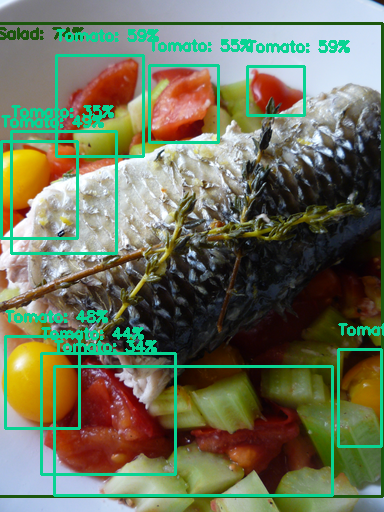

In [11]:
#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://storage.googleapis.com/cloud-ml-data/img/openimage/3/2520/3916261642_0a504acd60_o.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

## (Optional) Compile For the Edge TPU

Now that you have a quantized EfficientDet Lite model, it is possible to compile and deploy to a [Coral EdgeTPU](https://coral.ai/).

**Step 1. Install the EdgeTPU Compiler**

In [12]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2537  100  2537    0     0   154k      0 --:--:-- --:--:-- --:--:--  154k


OK


deb https://packages.cloud.google.com/apt coral-edgetpu-stable main



0% [Working]
            
Hit:1 http://us-west1.gce.archive.ubuntu.com/ubuntu focal InRelease

0% [Connecting to security.ubuntu.com (185.125.190.36)] [Connected to packages.
                                                                               
Hit:2 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease

                                                                               
Hit:3 http://us-west1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease

0% [Connecting to security.ubuntu.com (185.125.190.36)] [Waiting for headers] [
                                                                               
Hit:4 https://nvidia.github.io/libnvidia-container/stable/ubuntu18.04/amd64  InRelease

0% [Connecting to security.ubuntu.com (185.125.190.36)] [Waiting for headers] [
                                                                               
Hit:5 https://download.docker.com/linux/ubuntu focal InRelease

0% [Connecting to security.ubuntu.co


                                                                               
Hit:6 https://nvidia.github.io/nvidia-container-runtime/stable/ubuntu18.04/amd64  InRelease

0% [Connecting to security.ubuntu.com (185.125.190.36)] [Waiting for headers] [
                                                                               
Hit:7 https://nvidia.github.io/nvidia-docker/ubuntu18.04/amd64  InRelease

0% [Connecting to security.ubuntu.com (185.125.190.36)] [Waiting for headers] [
                                                                               
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease

0% [Connecting to security.ubuntu.com (185.125.190.36)] [Waiting for headers] [


0% [Connecting to security.ubuntu.com (185.125.190.36)] [Waiting for headers] [
                                                                               
Get:9 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6722 B]

0% [Waiting for headers] [9 InRelease 6722 B/6722 B 100%] [Connected to ppa.lau
                                                                               
0% [Waiting for headers] [Waiting for headers]


0% [Waiting for headers] [Waiting for headers]


                                              
Hit:10 https://apt.llvm.org/focal llvm-toolchain-focal-14 InRelease

0% [Waiting for headers] [Waiting for headers]
0% [Waiting for headers] [Waiting for headers]


                                              
Get:11 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]

0% [11 InRelease 12.6 kB/114 kB 11%] [Waiting for headers]
                                                          
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease

0% [11 InRelease 12.6 kB/114 kB 11%] [Connecting to ppa.launchpad.net (185.125.


0% [11 InRelease 12.6 kB/114 kB 11%] [Connecting to ppa.launchpad.net (185.125.


                                                                               
0% [11 InRelease 22.9 kB/114 kB 20%] [Waiting for headers]


0% [11 InRelease 42.2 kB/114 kB 37%] [Waiting for headers]
                                                          
Hit:13 http://ppa.launchpad.net/longsleep/golang-backports/ubuntu focal InRelease

                                                          
0% [11 InRelease 42.2 kB/114 kB 37%]


0% [11 InRelease 73.1 kB/114 kB 64%] [Connecting to ppa.launchpad.net (185.125.


                                                                               
0% [Waiting for headers]
0% [Waiting for headers]


0% [Waiting for headers]


                        
Hit:14 http://ppa.launchpad.net/openjdk-r/ppa/ubuntu focal InRelease

                        
0% [Working]


0% [Working]


            
Get:15 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages [2317 B]

0% [Working]
0% [15 Packages store 0 B]
                          
0% [Working]


0% [Working]


0% [Working]


0% [Working]


0% [Working]


100% [Working]
              
Fetched 123 kB in 1s (85.7 kB/s)



Reading package lists... 0%




Reading package lists... 0%

Reading package lists... 3%

Reading package lists... 3%

Reading package lists... 5%

Reading package lists... 5%

Reading package lists... 5%

Reading package lists... 5%

Reading package lists... 5%




Reading package lists... 35%




Reading package lists... 51%

Reading package lists... 51%

Reading package lists... 52%

Reading package lists... 52%

Reading package lists... 52%




Reading package lists... 59%

Reading package lists... 59%

Reading package lists... 64%




Reading package lists... 69%

Reading package lists... 69%

Reading package lists... 71%




Reading package lists... 74%

Reading package lists... 74%

Reading package lists... 75%

Reading package lists... 75%

Reading package lists... 75%

Reading package lists... 75%

Reading package lists... 75%

Reading package lists... 75%

Reading package lists... 75%

Reading package lists... 75%

Reading package lists... 76%

Reading package lists... 76%

Reading package lists... 76%

Reading package lists... 76%

Reading package lists... 76%

Reading package lists... 76%




Reading package lists... 82%

Reading package lists... 82%

Reading package lists... 86%

Reading package lists... 86%

Reading package lists... 90%




Reading package lists... 92%

Reading package lists... 92%

Reading package lists... 95%

Reading package lists... 95%

Reading package lists... 96%

Reading package lists... 96%

Reading package lists... 96%

Reading package lists... 96%

Reading package lists... 96%

Reading package lists... 96%

Reading package lists... 96%

Reading package lists... 96%

Reading package lists... 96%

Reading package lists... 96%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 98%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%

Reading package lists... 99%




Reading package lists... 99%




Reading package lists... Done




Reading package lists... 0%

Reading package lists... 100%

Reading package lists... Done


Building dependency tree... 0%




Building dependency tree... 50%




Building dependency tree       


Reading state information... 0%

Reading state information... 0%

Reading state information... Done



The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libparted-fs-resize0
Use 'sudo apt autoremove' to remove them.


The following NEW packages will be installed:
  edgetpu-compiler


0 upgraded, 1 newly installed, 0 to remove and 47 not upgraded.


Need to get 7913 kB of archives.
After this operation, 31.2 MB of additional disk space will be used.

0% [Working]


            
Get:1 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 edgetpu-compiler amd64 16.0 [7913 kB]

0% [1 edgetpu-compiler 3390 B/7913 kB 0%]


64% [1 edgetpu-compiler 6291 kB/7913 kB 80%]


                                            
100% [Working]
              
Fetched 7913 kB in 1s (8618 kB/s)


Selecting previously unselected package edgetpu-compiler.
(Reading database ... 
(Reading database ... 5%
(Reading database ... 10%
(Reading database ... 15%
(Reading database ... 20%
(Reading database ... 25%
(Reading database ... 30%
(Reading database ... 35%
(Reading database ... 40%
(Reading database ... 45%
(Reading database ... 50%
(Reading database ... 55%
(Reading database ... 60%
(Reading database ... 65%


(Reading database ... 75%
(Reading database ... 80%
(Reading database ... 85%
(Reading database ... 90%
(Reading database ... 95%
(Reading database ... 100%
(Reading database ... 140260 files and directories currently installed.)
Preparing to unpack .../edgetpu-compiler_16.0_amd64.deb ...
Unpacking edgetpu-compiler (16.0) ...


Setting up edgetpu-compiler (16.0) ...


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


**Step 2. Select number of Edge TPUs, Compile**

The EdgeTPU has 8MB of SRAM for caching model paramaters ([more info](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching)). This means that for models that are larger than 8MB, inference time will be increased in order to transfer over model paramaters. One way to avoid this is [Model Pipelining](https://coral.ai/docs/edgetpu/pipeline/) - splitting the model into segments that can have a dedicated EdgeTPU. This can significantly improve latency.

The below table can be used as a reference for the number of Edge TPUs to use - the larger models will not compile for a single TPU as the intermediate tensors can't fit in on-chip memory.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

In [13]:
NUMBER_OF_TPUS =  1#@param {type:"number"}

!edgetpu_compiler model.tflite --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.



Model compiled successfully in 4216 ms.

Input model: model.tflite
Input size: 4.24MiB
Output model: model_edgetpu.tflite
Output size: 5.61MiB
On-chip memory used for caching model parameters: 4.24MiB
On-chip memory remaining for caching model parameters: 3.27MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Number of operations that will run on CPU: 3
See the operation log file for individual operation details.


Compilation child process completed within timeout period.
Compilation succeeded! 


**Step 3. Download, Run Model**

With the model(s) compiled, they can now be run on EdgeTPU(s) for object detection. First, download the compiled TensorFlow Lite model file using the left sidebar of Colab. Right-click on the `model_edgetpu.tflite` file and choose `Download` to download it to your local computer.

Now you can run the model in your preferred manner. Examples of detection include:
* [pycoral detection](https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py)
* [Basic TFLite detection](https://github.com/google-coral/tflite/tree/master/python/examples/detection)
* [Example Video Detection](https://github.com/google-coral/examples-camera)
* [libcoral C++ API](https://github.com/google-coral/libcoral)


## Advanced Usage

This section covers advanced usage topics like adjusting the model and the training hyperparameters.

### Load the dataset

#### Load your own data

You can upload your own dataset to work through this tutorial. Upload your dataset by using the left sidebar in Colab.

<img src="https://storage.googleapis.com/download.tensorflow.org/models/tflite/screenshots/model_maker_object_detection.png" alt="Upload File" width="1000" hspace="0">

If you prefer not to upload your dataset to the cloud, you can also locally run the library by following the [guide](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

#### Load your data with a different data format

The Model Maker library also supports the `object_detector.DataLoader.from_pascal_voc` method to load data with [PASCAL VOC](https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5#:~:text=Pascal%20VOC%20is%20an%20XML,for%20training%2C%20testing%20and%20validation) format. [makesense.ai](https://www.makesense.ai/) and [LabelImg](https://github.com/tzutalin/labelImg) are the tools that can annotate the image and save annotations as XML files in PASCAL VOC data format:
```python
object_detector.DataLoader.from_pascal_voc(image_dir, annotations_dir, label_map={1: "person", 2: "notperson"})
```


### Customize the EfficientDet model hyperparameters

The model and training pipline parameters you can adjust are:

* `model_dir`: The location to save the model checkpoint files. If not set, a temporary directory will be used.
* `steps_per_execution`: Number of steps per training execution.
* `moving_average_decay`: Float. The decay to use for maintaining moving averages of the trained parameters.
* `var_freeze_expr`: The regular expression to map the prefix name of variables to be frozen which means remaining the same during training. More specific, use `re.match(var_freeze_expr, variable_name)` in the codebase to map the variables to be frozen.
* `tflite_max_detections`: integer, 25 by default. The max number of output detections in the TFLite model.
* `strategy`:  A string specifying which distribution strategy to use. Accepted values are 'tpu', 'gpus', None. tpu' means to use TPUStrategy. 'gpus' mean to use MirroredStrategy for multi-gpus. If None, use TF default with OneDeviceStrategy.
* `tpu`:  The Cloud TPU to use for training. This should be either the name used when creating the Cloud TPU, or a grpc://ip.address.of.tpu:8470 url.
* `use_xla`: Use XLA even if strategy is not tpu. If strategy is tpu, always use XLA, and this flag has no effect.
* `profile`: Enable profile mode.
* `debug`: Enable debug mode.

Other parameters that can be adjusted is shown in [hparams_config.py](https://github.com/google/automl/blob/df451765d467c5ed78bbdfd632810bc1014b123e/efficientdet/hparams_config.py#L170).


For instance, you can set the `var_freeze_expr='efficientnet'` which freezes the variables with name prefix `efficientnet` (default is `'(efficientnet|fpn_cells|resample_p6)'`). This allows the model to freeze untrainable variables and keep their value the same through training.

```python
spec = model_spec.get('efficientdet_lite0')
spec.config.var_freeze_expr = 'efficientnet'
```

### Change the Model Architecture

You can change the model architecture by changing the `model_spec`. For instance, change the `model_spec` to the EfficientDet-Lite4 model.

```python
spec = model_spec.get('efficientdet_lite4')
```

### Tune the training hyperparameters

The `create` function is the driver function that the Model Maker library uses to create models. The `model_spec` parameter defines the model specification. The `object_detector.EfficientDetSpec` class is currently supported. The `create` function comprises of the following steps:

1. Creates the model for the object detection according to `model_spec`.
2. Trains the model.  The default epochs and the default batch size are set by the `epochs` and `batch_size` variables in the `model_spec` object.
You can also tune the training hyperparameters like `epochs` and `batch_size` that affect the model accuracy. For instance,

*   `epochs`: Integer, 50 by default. More epochs could achieve better accuracy, but may lead to overfitting.
*   `batch_size`: Integer, 64 by default. The number of samples to use in one training step.
*   `train_whole_model`: Boolean, False by default. If true, train the whole model. Otherwise, only train the layers that do not match `var_freeze_expr`.

For example, you can train with less epochs and only the head layer. You can increase the number of epochs for better results.

```python
model = object_detector.create(train_data, model_spec=spec, epochs=10, validation_data=validation_data)
```

### Export to different formats

The export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`




By default, it exports only the TensorFlow Lite model file containing the model [metadata](https://www.tensorflow.org/lite/models/convert/metadata) so that you can later use in an on-device ML application. The label file is embedded in metadata.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you quantize the model to make it smaller and potentially run faster. As for EfficientDet-Lite models, full integer quantization  is used to quantize the model by default. Please refer to [Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) for more detail.

```python
model.export(export_dir='.')
```

You can also choose to export other files related to the model for better examination. For instance, exporting both the saved model and the label file as follows:
```python
model.export(export_dir='.', export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])
```

### Customize Post-training quantization on the TensorFlow Lite model

[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.

Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

```python
config = QuantizationConfig.for_float16()
```


Then we export the TensorFlow Lite model with such configuration.

```python
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)
```

# Read more

You can read our [object detection](https://www.tensorflow.org/lite/examples/object_detection/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/models/modify/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ObjectDetector](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

